# Swarm Intelligence Algorithms: ACO vs PSO
## Multi-Agent Task Scheduling Comparison

Perbandingan algoritma Ant Colony Optimization (ACO) dan Particle Swarm Optimization (PSO) untuk penjadwalan tugas multi-agent.

In [35]:
%pip install numpy pandas matplotlib seaborn ipywidgets


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [36]:
# Import libraries yang dibutuhkan
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown, Layout
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed untuk reproduksibilitas
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
print(f"Random seed set to: {RANDOM_SEED}")

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Random seed set to: 42


In [37]:
# from google.colab import drive
# drive.mount('/content/drive')

In [38]:
class MultiAgentScheduler:
    """Kelas dasar untuk penjadwalan tugas multi-agen dengan utilitas bersama."""

    def __init__(self, tasks, agents, cost_function, task_id_col='id', agent_id_col='id',
                 enable_dependencies=False, random_seed=None, num_default_agents=3):
        # Konversi input ke list jika DataFrame
        self.tugas = tasks.to_dict('records') if isinstance(tasks, pd.DataFrame) else tasks
        self.agen = agents.to_dict('records') if isinstance(agents, pd.DataFrame) else agents or [{agent_id_col: f'DefaultAgent-{i+1}'} for i in range(num_default_agents)]

        self.fungsi_biaya = cost_function
        self.task_id_col = task_id_col
        self.agent_id_col = agent_id_col
        self.enable_dependencies = enable_dependencies
        self.jumlah_tugas = len(self.tugas)
        self.jumlah_agen = len(self.agen)

        if self.jumlah_tugas == 0:
            print("Peringatan: Tidak ada tugas yang diberikan. Scheduler tidak akan berjalan.")

        # Penanganan dependensi
        self.peta_tugas = {str(task[self.task_id_col]): i for i, task in enumerate(self.tugas)}
        self.peta_tugas_terbalik = {i: str(task[self.task_id_col]) for i, task in enumerate(self.tugas)}
        self.dependensi = self.parse_dependencies() if enable_dependencies and self.jumlah_tugas > 0 else {}
        self.graf_dependensi = self.build_dependency_graph() if enable_dependencies and self.jumlah_tugas > 0 else None

        if enable_dependencies and self.jumlah_tugas > 0 and self.detect_circular_dependencies():
            print("Peringatan: Dependensi sirkular terdeteksi. Menggunakan fallback.")

        # Random seed
        if random_seed is not None:
            np.random.seed(random_seed)
            random.seed(random_seed)

        # Pelacakan
        self.jadwal_terbaik = None
        self.biaya_terbaik = float('inf')
        self.durasi_terbaik = float('inf')  # ADDED: Track makespan aktual
        self.indeks_keseimbangan_terbaik = float('inf')
        self.riwayat_iterasi = []

    def parse_dependencies(self):
        """Parse dependensi secara robust."""
        dependensi = {}
        for tugas in self.tugas:
            id_tugas = str(tugas[self.task_id_col])
            deps = None
            for field in ['dependencies', 'depends_on', 'prerequisites', 'requires', 'Dependencies']:
                if field in tugas and tugas[field] is not None:
                    deps = tugas[field]
                    break
            if deps:
                if isinstance(deps, str):
                    deps = [str(d).strip() for d in deps.replace(';', ',').split(',') if d.strip() and str(d).lower() not in ['null', 'nan', 'none', '']]
                elif isinstance(deps, (list, tuple)):
                    deps = [str(d).strip() for d in deps if d is not None and str(d).strip() and str(d).lower() not in ['null', 'nan', 'none']]
                else:
                    deps = [str(deps).strip()] if str(deps).strip() and str(deps).lower() not in ['null', 'nan', 'none'] else []
            dependensi[id_tugas] = deps or []
        return dependensi

    def build_dependency_graph(self):
        """Membangun graf dependensi."""
        return {id_tugas: self.dependensi[id_tugas] for id_tugas in self.dependensi}

    def detect_circular_dependencies(self):
        """Deteksi siklus menggunakan DFS."""
        if not self.enable_dependencies or self.jumlah_tugas == 0:
            return False
        visited, rec_stack = set(), set()
        def has_cycle(id_tugas):
            if id_tugas in rec_stack:
                return True
            if id_tugas in visited:
                return False
            visited.add(id_tugas)
            rec_stack.add(id_tugas)
            for dep_id in self.dependensi.get(id_tugas, []):
                if has_cycle(dep_id):
                    return True
            rec_stack.remove(id_tugas)
            return False
        for id_tugas in self.dependensi:
            if id_tugas not in visited and has_cycle(id_tugas):
                return True
        return False

    def is_dependency_satisfied(self, id_tugas, tugas_selesai):
        """Cek apakah dependensi terpenuhi."""
        return all(dep_id in tugas_selesai for dep_id in self.dependensi.get(id_tugas, []))

    def get_ready_tasks(self, tugas_tersisa, tugas_selesai):
        """Dapatkan tugas yang siap dijalankan."""
        if not self.enable_dependencies:
            return tugas_tersisa
        return [idx for idx in tugas_tersisa if self.is_dependency_satisfied(self.peta_tugas_terbalik[idx], tugas_selesai)]

    def calculate_load_balance_index(self, waktu_selesai_agen):
        """Hitung indeks keseimbangan beban."""
        times = list(waktu_selesai_agen.values())
        if len(times) <= 1:
            return 0.0
        waktu_rata = sum(times) / len(times)
        if waktu_rata == 0:
            return 0.0
        variance = sum((t - waktu_rata) ** 2 for t in times) / len(times)
        return (variance ** 0.5) / waktu_rata

    def find_best_agent(self, waktu_selesai_agen, durasi_tugas, id_tugas=None, waktu_selesai_tugas=None, prioritize_balance=True):
        """Temukan agen terbaik untuk tugas."""
        if not waktu_selesai_agen:
            return self.agen[0][self.agent_id_col] if self.agen else None

        agen_terbaik = None
        skor_terbaik = float('inf')
        max_saat_ini = max(waktu_selesai_agen.values(), default=0)

        waktu_dep_selesai = 0
        if self.enable_dependencies and id_tugas and waktu_selesai_tugas:
            dep_finish_times = [waktu_selesai_tugas.get(dep_id, 0) for dep_id in self.dependensi.get(id_tugas, [])]
            waktu_dep_selesai = max(dep_finish_times) if dep_finish_times else 0

        for agen in self.agen:
            id_agen = agen[self.agent_id_col]
            waktu_temp = waktu_selesai_agen.copy()
            waktu_mulai = max(waktu_temp.get(id_agen, 0), waktu_dep_selesai)
            waktu_temp[id_agen] = waktu_mulai + durasi_tugas
            durasi_total_baru = max(waktu_temp.values())

            if prioritize_balance:
                skor_keseimbangan = self.calculate_load_balance_index(waktu_temp)
                skor = skor_keseimbangan * 1000 + (durasi_total_baru / 1000)
            else:
                penalti_keseimbangan = self.calculate_load_balance_index(waktu_temp) * max_saat_ini * 2
                skor = durasi_total_baru + penalti_keseimbangan

            if skor < skor_terbaik:
                skor_terbaik = skor
                agen_terbaik = id_agen

        return agen_terbaik or min(waktu_selesai_agen, key=waktu_selesai_agen.get, default=self.agen[0][self.agent_id_col] if self.agen else None)

    def assign_to_agents(self, urutan_indeks_tugas):
        """Assign tugas ke agen."""
        if not self.agen or (isinstance(urutan_indeks_tugas, np.ndarray) and urutan_indeks_tugas.size == 0) or (isinstance(urutan_indeks_tugas, list) and not urutan_indeks_tugas):
            return [], {}, 0.0

        waktu_selesai_agen = {agen[self.agent_id_col]: 0 for agen in self.agen}
        waktu_selesai_tugas = {}
        jadwal = []

        for indeks_tugas in urutan_indeks_tugas:
            tugas = self.tugas[indeks_tugas]
            id_tugas = str(tugas[self.task_id_col])
            durasi = tugas.get('length', tugas.get('duration', 1))

            agen_terbaik = self.find_best_agent(waktu_selesai_agen, durasi, id_tugas, waktu_selesai_tugas)
            if agen_terbaik is None:
                continue

            waktu_dep_selesai = 0
            if self.enable_dependencies and id_tugas in self.dependensi:
                dep_finish_times = [waktu_selesai_tugas.get(dep_id, 0) for dep_id in self.dependensi[id_tugas]]
                waktu_dep_selesai = max(dep_finish_times) if dep_finish_times else 0

            waktu_mulai = max(waktu_selesai_agen[agen_terbaik], waktu_dep_selesai)
            waktu_akhir = waktu_mulai + durasi
            waktu_selesai_agen[agen_terbaik] = waktu_akhir
            waktu_selesai_tugas[id_tugas] = waktu_akhir

            jadwal.append({'task_id': id_tugas, 'agent_id': agen_terbaik, 'start_time': waktu_mulai, 'finish_time': waktu_akhir})

        durasi_total = max(waktu_selesai_agen.values(), default=0)
        keseimbangan_beban = self.calculate_load_balance_index(waktu_selesai_agen)
        return jadwal, waktu_selesai_agen, keseimbangan_beban

    def optimize(self, n_iterations=100, show_progress=True):
        """Metode optimasi utama."""
        if self.jumlah_tugas == 0 or self.jumlah_agen == 0:
            if show_progress:
                print("Tidak dapat berjalan: Tidak ada tugas atau agen.")
            return {
                'schedule': pd.DataFrame(), 'makespan': 0.0, 'load_balance_index': 0.0,
                'agent_finish_times': {}, 'computation_time': 0.0,
                'iteration_history': pd.DataFrame(), 'algorithm': self.__class__.__name__
            }

        waktu_mulai = time.time()
        if show_progress:
            print(f"Memulai optimasi {self.__class__.__name__}...")

        # Inisialisasi jadwal dan biaya terbaik
        urutan_awal = list(range(self.jumlah_tugas))
        jadwal_awal, waktu_agen_awal, keseimbangan_awal = self.assign_to_agents(urutan_awal)
        durasi_total_awal = max(waktu_agen_awal.values(), default=0)
        self.biaya_terbaik = self.fungsi_biaya(jadwal_awal, durasi_total_awal)
        self.durasi_terbaik = durasi_total_awal  # FIXED: Track makespan aktual
        self.jadwal_terbaik = jadwal_awal
        self.indeks_keseimbangan_terbaik = keseimbangan_awal

        for i in range(n_iterations):
            pass

        waktu_komputasi = time.time() - waktu_mulai
        waktu_akhir_agen = {}
        if self.jadwal_terbaik:
            for penugasan in self.jadwal_terbaik:
                waktu_akhir_agen[penugasan['agent_id']] = max(waktu_akhir_agen.get(penugasan['agent_id'], 0), penugasan['finish_time'])

        return {
            'schedule': pd.DataFrame(self.jadwal_terbaik) if self.jadwal_terbaik else pd.DataFrame(),
            'makespan': self.durasi_terbaik if self.durasi_terbaik != float('inf') else 0.0,  # FIXED: Return makespan, bukan biaya
            'load_balance_index': self.indeks_keseimbangan_terbaik if self.indeks_keseimbangan_terbaik != float('inf') else 0.0,
            'agent_finish_times': waktu_akhir_agen,
            'computation_time': waktu_komputasi,
            'iteration_history': pd.DataFrame(self.riwayat_iterasi),
            'algorithm': self.__class__.__name__
        }

    def run(self):
        """Jalankan optimasi dengan yield progress."""
        hasil = self.optimize(show_progress=False)
        for _, row in hasil['iteration_history'].iterrows():
            yield f'{{"type": "iteration", "iteration": {row["iteration"]}, "makespan": {row["best_makespan"]:.2f}}}'
        yield f'{{"type": "done", "schedule": {hasil["schedule"].to_dict("records")}, "makespan": {hasil["makespan"]}, "load_balance_index": {hasil["load_balance_index"]}, "agent_finish_times": {hasil["agent_finish_times"]}}}'

class ACO_MultiAgent_Scheduler(MultiAgentScheduler):
    """Implementasi ACO (Ant Colony Optimization)."""

    def __init__(self, tasks, cost_function, heuristic_function, agents=None, n_ants=10, n_iterations=100,
                 alpha=1.0, beta=2.0, evaporation_rate=0.5, pheromone_deposit=100.0, **kwargs):
        super().__init__(tasks, agents, cost_function, **kwargs)
        self.fungsi_heuristik = heuristic_function
        self.jumlah_semut = n_ants if self.jumlah_tugas > 0 else 0
        self.jumlah_iterasi = n_iterations if self.jumlah_tugas > 0 else 0
        self.alpha, self.beta = alpha, beta
        self.tingkat_penguapan, self.deposit_feromon = evaporation_rate, pheromone_deposit
        self.prioritize_balance = True

        if self.jumlah_tugas > 0:
            self.feromon = np.ones((self.jumlah_tugas, self.jumlah_tugas))
            self.heuristik = self.calculate_heuristics()
        else:
            self.feromon = self.heuristik = np.array([[]])

    def calculate_heuristics(self):
        """Hitung nilai heuristik untuk semua pasangan tugas."""
        heuristik = np.zeros((self.jumlah_tugas, self.jumlah_tugas))
        for i in range(self.jumlah_tugas):
            for j in range(self.jumlah_tugas):
                if i != j:
                    heuristik[i, j] = self.fungsi_heuristik(self.tugas[j])
        return heuristik

    def construct_solution(self):
        """Konstruksi solusi oleh satu semut."""
        if self.jumlah_tugas == 0:
            return []
        rute, tersisa = [], set(range(self.jumlah_tugas))
        selesai = set()
        saat_ini = None
        iterasi_maks = self.jumlah_tugas * 2
        hitung_iterasi = 0

        while tersisa and hitung_iterasi < iterasi_maks:
            hitung_iterasi += 1
            siap = self.get_ready_tasks(list(tersisa), selesai)

            if not siap:
                min_tidak_terpenuhi = float('inf')
                tugas_paksa = None
                for idx in tersisa:
                    tid = self.peta_tugas_terbalik[idx]
                    tidak_terpenuhi = len([d for d in self.dependensi.get(tid, []) if d not in selesai])
                    if tidak_terpenuhi < min_tidak_terpenuhi:
                        min_tidak_terpenuhi, tugas_paksa = tidak_terpenuhi, idx
                siap = [tugas_paksa] if tugas_paksa is not None else []

            if not siap:
                break

            if saat_ini is None or saat_ini not in siap:
                tugas_berikutnya = random.choice(siap)
            else:
                probabilitas = self.calculate_probabilities(saat_ini, siap)
                tugas_berikutnya = np.random.choice(siap, p=probabilitas) if len(siap) > 1 else siap[0]

            rute.append(tugas_berikutnya)
            tersisa.remove(tugas_berikutnya)
            selesai.add(self.peta_tugas_terbalik[tugas_berikutnya])
            saat_ini = tugas_berikutnya

        rute.extend(sorted(tersisa))
        return rute

    def calculate_probabilities(self, saat_ini, belum_dikunjungi):
        """Hitung probabilitas pemilihan tugas berikutnya."""
        if not belum_dikunjungi:
            return np.array([])
        phero = self.feromon[saat_ini, belum_dikunjungi] ** self.alpha
        heur = self.heuristik[saat_ini, belum_dikunjungi] ** self.beta
        keinginan = phero * heur
        total = np.sum(keinginan)
        return keinginan / total if total > 0 else np.ones(len(belum_dikunjungi)) / len(belum_dikunjungi)

    def update_pheromones(self, rute_list, biaya_list):
        """Update matriks feromon berdasarkan solusi."""
        if not rute_list or self.jumlah_tugas == 0:
            return
        self.feromon *= (1 - self.tingkat_penguapan)
        for rute, biaya in zip(rute_list, biaya_list):
            if biaya == 0 or len(rute) < 2:
                continue
            tambah = self.deposit_feromon / biaya
            for i in range(len(rute) - 1):
                self.feromon[rute[i], rute[i+1]] += tambah
            if len(rute) >= 2:
                self.feromon[rute[-1], rute[0]] += tambah

    def optimize(self, show_progress=True, progress_callback=None):
        """Optimasi menggunakan ACO."""
        urutan_awal = list(range(self.jumlah_tugas))
        jadwal_awal, waktu_agen_awal, keseimbangan_awal = self.assign_to_agents(urutan_awal)
        durasi_total_awal = max(waktu_agen_awal.values(), default=0)
        self.biaya_terbaik = self.fungsi_biaya(jadwal_awal, durasi_total_awal)
        self.durasi_terbaik = durasi_total_awal  # Simpan makespan aktual
        self.jadwal_terbaik = jadwal_awal
        self.indeks_keseimbangan_terbaik = keseimbangan_awal

        waktu_mulai = time.time()

        for i in range(self.jumlah_iterasi):
            rute_list, biaya_list = [], []
            ada_terbaik_baru = False

            for _ in range(self.jumlah_semut):
                urutan = self.construct_solution()
                if urutan:
                    jadwal, waktu_agen, indeks_keseimbangan = self.assign_to_agents(urutan)
                    durasi_total = max(waktu_agen.values(), default=0)
                    biaya = self.fungsi_biaya(jadwal, durasi_total)
                    rute_list.append(urutan)
                    biaya_list.append(biaya)

                    if biaya < self.biaya_terbaik or (biaya == self.biaya_terbaik and indeks_keseimbangan < self.indeks_keseimbangan_terbaik):
                        self.biaya_terbaik = biaya
                        self.durasi_terbaik = durasi_total  # Simpan makespan aktual
                        self.jadwal_terbaik = jadwal
                        self.indeks_keseimbangan_terbaik = indeks_keseimbangan
                        ada_terbaik_baru = True
                else:
                    rute_list.append([])
                    biaya_list.append(float('inf'))

            self.update_pheromones(rute_list, biaya_list)

            self.riwayat_iterasi.append({
                'iteration': i + 1,
                'best_makespan': self.durasi_terbaik if self.durasi_terbaik != float('inf') else 0.0,
                'load_balance': self.indeks_keseimbangan_terbaik if self.indeks_keseimbangan_terbaik != float('inf') else 0.0
            })

            # Real-time streaming callback
            if progress_callback:
                progress_callback({
                    'iteration': i + 1,
                    'best_makespan': self.durasi_terbaik if self.durasi_terbaik != float('inf') else 0.0,
                    'load_balance': self.indeks_keseimbangan_terbaik if self.indeks_keseimbangan_terbaik != float('inf') else 0.0
                })

            if show_progress and ada_terbaik_baru:
                print(f"Iterasi {i+1}: Terbaik baru! Makespan: {self.durasi_terbaik:.2f}, Load Balance: {self.indeks_keseimbangan_terbaik:.4f}")
            elif show_progress:
                print(f"Iterasi {i+1}: Makespan Terbaik: {self.durasi_terbaik:.2f}, Load Balance: {self.indeks_keseimbangan_terbaik:.4f}")

        waktu_akhir_agen_final = {}
        if self.jadwal_terbaik:
            for penugasan in self.jadwal_terbaik:
                id_agen = penugasan['agent_id']
                waktu_akhir = penugasan['finish_time']
                waktu_akhir_agen_final[id_agen] = max(waktu_akhir_agen_final.get(id_agen, 0), waktu_akhir)

        return {
            'schedule': pd.DataFrame(self.jadwal_terbaik) if self.jadwal_terbaik else pd.DataFrame(),
            'makespan': self.durasi_terbaik if self.durasi_terbaik != float('inf') else 0.0,
            'load_balance_index': self.indeks_keseimbangan_terbaik if self.indeks_keseimbangan_terbaik != float('inf') else 0.0,
            'agent_finish_times': waktu_akhir_agen_final,
            'computation_time': time.time() - waktu_mulai,
            'iteration_history': pd.DataFrame(self.riwayat_iterasi),
            'algorithm': self.__class__.__name__
        }

class PSO_MultiAgent_Scheduler(MultiAgentScheduler):
    """Implementasi PSO (Particle Swarm Optimization)."""

    def __init__(self, tasks, agents, cost_function, n_particles=30, n_iterations=100, w=0.5, c1=1.5, c2=1.5, **kwargs):
        super().__init__(tasks, agents, cost_function, **kwargs)
        self.jumlah_partikel = n_particles if self.jumlah_tugas > 0 else 0
        self.jumlah_iterasi = n_iterations if self.jumlah_tugas > 0 else 0
        self.w, self.c1, self.c2 = w, c1, c2

        if self.jumlah_tugas > 0 and self.jumlah_partikel > 0:
            self.posisi = np.random.rand(self.jumlah_partikel, self.jumlah_tugas)
            self.kecepatan = np.random.rand(self.jumlah_partikel, self.jumlah_tugas) * 0.1
            self.posisi_pbest = self.posisi.copy()
            self.biaya_pbest = np.full(self.jumlah_partikel, float('inf'))
            self.durasi_pbest = np.full(self.jumlah_partikel, float('inf'))  # ADDED: Track durasi per particle
            self.posisi_gbest = None

            if self.jumlah_partikel > 0:
                 self.posisi_gbest = self.posisi[0].copy()
        else:
            self.posisi = self.kecepatan = self.posisi_pbest = np.array([[]])
            self.biaya_pbest = np.array([])
            self.durasi_pbest = np.array([])
            self.posisi_gbest = None

    def position_to_sequence(self, posisi):
        """Konversi posisi partikel ke urutan tugas."""
        if self.jumlah_tugas == 0:
            return []
        if not self.enable_dependencies:
            return np.argsort(posisi)

        # Koreksi berbasis penalti
        urutan = np.argsort(posisi)
        penalti = {}
        selesai = set()
        tersedia = set(urutan)
        terkoreksi = []
        iterasi_maks = self.jumlah_tugas * 2

        daftar_id_tugas = [str(tugas[self.task_id_col]) for tugas in self.tugas]

        for indeks_tugas in urutan:
            tid = daftar_id_tugas[indeks_tugas]
            prioritas_dasar = posisi[indeks_tugas]
            dep_tidak_terpenuhi = sum(1 for dep in self.dependensi.get(tid, []) if dep not in selesai)
            penalti[indeks_tugas] = prioritas_dasar - (dep_tidak_terpenuhi * 0.5)

        hitung_iterasi = 0
        while tersedia and hitung_iterasi < iterasi_maks:
            hitung_iterasi += 1
            siap = [idx for idx in tersedia if self.is_dependency_satisfied(daftar_id_tugas[idx], selesai)]
            if siap:
                terbaik = max(siap, key=lambda t: penalti[t])
                terkoreksi.append(terbaik)
                tersedia.remove(terbaik)
                selesai.add(daftar_id_tugas[terbaik])
            else:
                # Fallback: min deps (SAMA DENGAN BACKEND)
                fallback = min(tersedia, key=lambda t: len(self.dependensi.get(daftar_id_tugas[t], [])))
                terkoreksi.append(fallback)
                tersedia.remove(fallback)
                selesai.add(daftar_id_tugas[fallback])

        terkoreksi.extend(sorted(tersedia))
        return np.array(terkoreksi)

    def position_to_schedule(self, posisi):
        """Konversi posisi ke jadwal."""
        urutan = self.position_to_sequence(posisi)
        jadwal, waktu_selesai_agen, keseimbangan_beban = self.assign_to_agents(urutan)
        return jadwal, waktu_selesai_agen

    def optimize(self, show_progress=True, progress_callback=None):
        """Optimasi menggunakan PSO."""
        if self.jumlah_partikel == 0 or self.jumlah_tugas == 0:
            return super().optimize(show_progress=False)

        waktu_mulai = time.time()
        if show_progress:
            print(f"Memulai optimasi {self.__class__.__name__}...")

        urutan_awal = self.position_to_sequence(self.posisi[0])
        jadwal_awal, waktu_agen_awal, keseimbangan_awal = self.assign_to_agents(urutan_awal)
        durasi_total_awal = max(waktu_agen_awal.values(), default=0)
        self.biaya_terbaik = self.fungsi_biaya(jadwal_awal, durasi_total_awal)
        self.durasi_terbaik = durasi_total_awal  # FIXED: Track makespan aktual
        self.jadwal_terbaik = jadwal_awal
        self.indeks_keseimbangan_terbaik = keseimbangan_awal

        for i in range(self.jumlah_iterasi):
            ada_terbaik_baru = False

            for p in range(self.jumlah_partikel):
                jadwal, waktu_agen = self.position_to_schedule(self.posisi[p])
                durasi_total = max(waktu_agen.values(), default=0)
                indeks_keseimbangan = self.calculate_load_balance_index(waktu_agen)
                biaya = self.fungsi_biaya(jadwal, durasi_total)

                if biaya < self.biaya_pbest[p]:
                    self.biaya_pbest[p] = biaya
                    self.durasi_pbest[p] = durasi_total  # ADDED: Track durasi per particle
                    self.posisi_pbest[p] = self.posisi[p].copy()

                if biaya < self.biaya_terbaik or (biaya == self.biaya_terbaik and indeks_keseimbangan < self.indeks_keseimbangan_terbaik):
                    self.biaya_terbaik = biaya
                    self.durasi_terbaik = durasi_total  # FIXED: Track makespan aktual
                    self.jadwal_terbaik = jadwal
                    self.indeks_keseimbangan_terbaik = indeks_keseimbangan
                    self.posisi_gbest = self.posisi[p].copy()
                    ada_terbaik_baru = True

            if self.posisi_gbest is not None:
                for p in range(self.jumlah_partikel):
                    r1, r2 = np.random.rand(self.jumlah_tugas), np.random.rand(self.jumlah_tugas)
                    kognitif = self.c1 * r1 * (self.posisi_pbest[p] - self.posisi[p])
                    sosial = self.c2 * r2 * (self.posisi_gbest - self.posisi[p])
                    self.kecepatan[p] = self.w * self.kecepatan[p] + kognitif + sosial
                    self.posisi[p] += self.kecepatan[p]

            self.riwayat_iterasi.append({
                'iteration': i + 1,
                'best_makespan': self.durasi_terbaik if self.durasi_terbaik != float('inf') else 0.0,  # FIXED: Use durasi
                'load_balance': self.indeks_keseimbangan_terbaik if self.indeks_keseimbangan_terbaik != float('inf') else 0.0
            })

            # Real-time streaming callback
            if progress_callback:
                progress_callback({
                    'iteration': i + 1,
                    'best_makespan': self.durasi_terbaik if self.durasi_terbaik != float('inf') else 0.0,
                    'load_balance': self.indeks_keseimbangan_terbaik if self.indeks_keseimbangan_terbaik != float('inf') else 0.0
                })

            if show_progress and ada_terbaik_baru:
                print(f"Iterasi {i+1}: Terbaik baru! Makespan: {self.durasi_terbaik:.2f}, Load Balance: {self.indeks_keseimbangan_terbaik:.4f}")
            elif show_progress:
                print(f"Iterasi {i+1}: Makespan Terbaik: {self.durasi_terbaik:.2f}, Load Balance: {self.indeks_keseimbangan_terbaik:.4f}")

        waktu_akhir_agen_final = {}
        if self.posisi_gbest is not None:
            self.jadwal_terbaik, waktu_akhir_agen_final = self.position_to_schedule(self.posisi_gbest)

        waktu_komputasi = time.time() - waktu_mulai

        return {
            'schedule': pd.DataFrame(self.jadwal_terbaik) if self.jadwal_terbaik else pd.DataFrame(),
            'makespan': self.durasi_terbaik if self.durasi_terbaik != float('inf') else 0.0,  # FIXED: Return makespan aktual
            'load_balance_index': self.indeks_keseimbangan_terbaik if self.indeks_keseimbangan_terbaik != float('inf') else 0.0,
            'agent_finish_times': waktu_akhir_agen_final,
            'computation_time': waktu_komputasi,
            'iteration_history': pd.DataFrame(self.riwayat_iterasi),
            'algorithm': self.__class__.__name__
        }


# Alias untuk kompatibilitas
ACOScheduler = ACO_MultiAgent_Scheduler
PSOScheduler = PSO_MultiAgent_Scheduler

## Dataset Configuration & Data Loading

In [39]:
import ipywidgets as widgets
from IPython.display import display, HTML

# Kelas konfigurasi dinamis untuk menyimpan parameter
class DynamicConfig:
    """Objek konfigurasi dinamis."""
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

    def __repr__(self):
        return f"DynamicConfig({', '.join(f'{k}={v}' for k, v in self.__dict__.items())})"

    def tampilkan_params(self, nama_algoritma):
        """Tampilkan parameter untuk algoritma tertentu."""
        params = {k: v for k, v in self.__dict__.items() if k.startswith(nama_algoritma.lower() + '_')}
        print(f"Parameter {nama_algoritma}:")
        for key, value in params.items():
            print(f"  {key}: {value}")

LOKASI_DATASET_DEPENDENSI = "../data/cloud_task_scheduling_fix.csv"


# Nilai-nilai ini digunakan di seluruh notebook
config = DynamicConfig(
    maks_tugas = 100,
    jumlah_agen = 10,

    aco_jumlah_semut = 50,
    aco_jumlah_iterasi = 100,
    aco_alpha = 0.9,
    aco_beta = 2,
    aco_tingkat_penguapan = 0.3,
    aco_deposit_feromon = 100,
    aco_aktifkan_dependensi = False,

    pso_jumlah_partikel = 50,
    pso_jumlah_iterasi = 100,
    pso_w = 0.3,
    pso_c1 = 0.3,
    pso_c2 = 0.4,
    pso_aktifkan_dependensi = False,

    # Balancing
    bobot_biaya = 1.0,
    bobot_waktu = 1.0,
    bobot_keseimbangan_beban = 1.0
)

print("Konfigurasi dimuat. Anda dapat memodifikasi atribut objek 'config' di bawah.")
print("Konfigurasi Saat Ini:")
display(config)



Konfigurasi dimuat. Anda dapat memodifikasi atribut objek 'config' di bawah.
Konfigurasi Saat Ini:


DynamicConfig(maks_tugas=100, jumlah_agen=10, aco_jumlah_semut=50, aco_jumlah_iterasi=100, aco_alpha=0.9, aco_beta=2, aco_tingkat_penguapan=0.3, aco_deposit_feromon=100, aco_aktifkan_dependensi=False, pso_jumlah_partikel=50, pso_jumlah_iterasi=100, pso_w=0.3, pso_c1=0.3, pso_c2=0.4, pso_aktifkan_dependensi=False, bobot_biaya=1.0, bobot_waktu=1.0, bobot_keseimbangan_beban=1.0)

In [40]:
# ========== FUNGSI HELPER ==========
def coba_ambil_nilai(obj, keys, default=None):
    """Coba ambil nilai dari dict dengan multiple key alternatif, return default jika tidak ada."""
    if not isinstance(obj, dict):
        return default
    for key in (keys if isinstance(keys, list) else [keys]):
        if key in obj and pd.notna(obj[key]):
            return obj[key]
    return default

def dapatkan_id_tugas(tugas):
    """Dapatkan ID tugas dari berbagai format."""
    if not isinstance(tugas, dict):
        return str(tugas)
    nilai = coba_ambil_nilai(tugas, ['id', 'task_id', 'Task_ID'])
    return str(int(nilai)) if nilai else str(random.randint(1000, 9999))

def dapatkan_id_agen(agen):
    """Dapatkan ID agen dari berbagai format."""
    if not isinstance(agen, dict):
        return str(agen)
    return coba_ambil_nilai(agen, ['id', 'agent_id', 'Agent_ID'], str(agen))

def dapatkan_durasi_tugas(tugas):
    """Dapatkan durasi tugas dari berbagai format."""
    return coba_ambil_nilai(tugas, ['duration', 'Duration', 'execution_time', 'execution_time (s)',
                           'Execution_Time', 'length'], 1) if isinstance(tugas, dict) else 1

def dapatkan_efisiensi_agen(agen):
    """Dapatkan efisiensi agen dari berbagai format."""
    return coba_ambil_nilai(agen, ['efficiency', 'Efficiency', 'capacity', 'Capacity'],
                    1.0) if isinstance(agen, dict) else 1.0


# ========== FUNGSI PARSING ==========
def parse_nilai(nilai, tipe_nilai=float, default=None, karakter_bersih=''):
    """Parse nilai dengan pembersihan karakter dan konversi tipe."""
    try:
        if pd.isna(nilai):
            return default
        dibersihkan = str(nilai)
        for char in karakter_bersih:
            dibersihkan = dibersihkan.replace(char, '')
        return tipe_nilai(dibersihkan.strip())
    except (ValueError, TypeError):
        return default

def parse_dependensi(string_dep):
    """Parse string dependencies menjadi list."""
    if pd.isna(string_dep) or not str(string_dep).strip():
        return []

    dep_str = str(string_dep).strip()
    pemisah = ';' if ';' in dep_str else ','
    deps = [d.strip() for d in dep_str.split(pemisah) if d.strip()]

    # Filter nilai tidak valid
    nilai_tidak_valid = {'null', 'nan', 'none', ''}
    return [str(d) for d in deps if str(d).lower() not in nilai_tidak_valid]

def parse_baris_tugas(baris, kolom_dependensi=None):
    """Parse satu baris task data menjadi dictionary."""
    data_tugas = baris.to_dict()

    # Parse setiap field dengan fungsi helper
    id_tugas = dapatkan_id_tugas(data_tugas)
    durasi = parse_nilai(
        coba_ambil_nilai(data_tugas, ['duration', 'execution_time', 'execution_time (s)',
                            'execution_time(s)', 'length']),
        float, 1.0, '(s)MB%'
    )
    penggunaan_cpu = parse_nilai(
        coba_ambil_nilai(data_tugas, ['cpu_usage', 'cpu_usage (%)']),
        int, 0, '%'
    )
    penggunaan_ram = parse_nilai(
        coba_ambil_nilai(data_tugas, ['ram_usage', 'ram_usage (mb)']),
        int, 0, 'MB'
    )
    prioritas = parse_nilai(coba_ambil_nilai(data_tugas, ['priority']), int, 1)
    biaya = parse_nilai(coba_ambil_nilai(data_tugas, ['cost']), float, durasi)

    # Parse dependencies
    deps = []
    if kolom_dependensi and kolom_dependensi in data_tugas:
        deps = parse_dependensi(data_tugas[kolom_dependensi])

    # Hitung kompleksitas
    kompleksitas = min(1.0, (penggunaan_cpu + penggunaan_ram/1000) / 200) if penggunaan_cpu and penggunaan_ram else 0.5

    return {
        'id': id_tugas,
        'duration': durasi,
        'cpu_usage': penggunaan_cpu,
        'ram_usage': penggunaan_ram,
        'priority': prioritas,
        'cost': biaya,
        'dependencies': deps,
        'complexity': kompleksitas
    }


# ========== LOADING DATASET ==========
def cari_kolom_dependensi(df):
    """Temukan kolom dependencies dalam dataframe."""
    kolom_dep = ['dependencies', 'depends_on', 'prerequisites', 'requires']
    return next((col for col in kolom_dep if col in df.columns), None)

def muat_dataset_dependensi(lokasi_file, maks_tugas=None):
    """Load dataset dengan dependencies dari CSV file."""
    print("\n" + "=" * 50)
    print("Memuat Dataset Dependensi...")
    print("=" * 50)

    # Load CSV
    try:
        df_tugas = pd.read_csv(lokasi_file)
        df_tugas.columns = df_tugas.columns.str.lower()
        print("DataFrame berhasil dimuat")
        display(df_tugas.head())
    except FileNotFoundError:
        print(f"Error: File tidak ditemukan di {lokasi_file}")
        return [], []
    except Exception as e:
        print(f"Error membaca CSV: {e}")
        return [], []

    # Limit tasks jika diperlukan
    if maks_tugas:
        df_tugas = df_tugas.head(maks_tugas)

    # Parse tasks
    kolom_dependensi = cari_kolom_dependensi(df_tugas)
    daftar_tugas = [parse_baris_tugas(baris, kolom_dependensi) for _, baris in df_tugas.iterrows()]

    # Generate agents
    jumlah_agen = max(1 if daftar_tugas else 0, config.jumlah_agen)
    daftar_agen = generate_agen_default(jumlah_agen)

    filter_ghost_dependencies(daftar_tugas)

    # Print summary
    print(f"\nDimuat: {len(daftar_tugas)} tugas, {len(daftar_agen)} agen")

    # Validate dependencies
    if daftar_tugas and any(tugas.get('dependencies') for tugas in daftar_tugas):
        print("\nMemvalidasi Dependensi...")
        validasi_dependensi(daftar_tugas)
        cetak_statistik_dependensi(daftar_tugas)
    else:
        print("\nTidak ada dependencies dalam dataset")

    cetak_ringkasan_dataset(daftar_tugas, daftar_agen)
    return daftar_tugas, daftar_agen


# ========== GENERATE AGEN ==========
def generate_agen_default(jumlah_agen):
    """Generate default agents dengan kapabilitas bervariasi."""
    if jumlah_agen <= 0:
        return []

    tipe_agen = ['High_Performance', 'Medium_Performance', 'Standard', 'Basic']
    kapasitas = [1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7]
    efisiensi = [1.2, 1.1, 1.0, 0.9, 0.8, 0.7]

    return [{
        'id': f'Agent_{i+1}',
        'type': tipe_agen[i % len(tipe_agen)],
        'capacity': kapasitas[i % len(kapasitas)],
        'efficiency': efisiensi[i % len(efisiensi)]
    } for i in range(jumlah_agen)]


# ========== FUNGSI BIAYA ==========
def fungsi_biaya_per_tugas(tugas, agen):
    """
    Fungsi biaya untuk menghitung cost assignment SATU tugas ke SATU agen.
    Digunakan untuk: Heuristic function di ACO, perhitungan individual.

    SAMA dengan Flask: Mempertimbangkan duration, efficiency, capacity, complexity.
    """
    # Ambil durasi tugas
    waktu_dasar = 1.0
    for field in ['duration', 'Duration', 'length', 'Length', 'execution_time']:
        if isinstance(tugas, dict) and field in tugas:
            val = tugas[field]
            if val is not None and not (isinstance(val, float) and pd.isna(val)):
                try:
                    waktu_dasar = float(val)
                    break
                except (ValueError, TypeError):
                    pass
    waktu_dasar = max(waktu_dasar, 0.1)

    # Ambil efisiensi agen
    efisiensi_agen = 1.0
    for field in ['efficiency', 'Efficiency']:
        if isinstance(agen, dict) and field in agen:
            val = agen[field]
            if val is not None:
                try:
                    efisiensi_agen = float(val)
                    break
                except (ValueError, TypeError):
                    pass
    efisiensi_agen = max(efisiensi_agen, 0.1)

    # Ambil kapasitas agen
    kapasitas_agen = 1.0
    for field in ['capacity', 'Capacity']:
        if isinstance(agen, dict) and field in agen:
            val = agen[field]
            if val is not None:
                try:
                    kapasitas_agen = float(val)
                    break
                except (ValueError, TypeError):
                    pass
    kapasitas_agen = max(kapasitas_agen, 0.1)

    # Ambil kompleksitas tugas
    kompleksitas = 0.5
    if isinstance(tugas, dict):
        if 'complexity' in tugas and tugas['complexity'] is not None:
            try:
                kompleksitas = float(tugas['complexity'])
            except (ValueError, TypeError):
                pass
        else:
            # Hitung dari CPU dan RAM jika ada
            cpu = 0
            ram = 0
            for field in ['cpu_usage', 'CPU_Usage', 'cpu']:
                if field in tugas and tugas[field] is not None:
                    try:
                        cpu = float(str(tugas[field]).replace('%', ''))
                        break
                    except:
                        pass
            for field in ['ram_usage', 'RAM_Usage', 'ram']:
                if field in tugas and tugas[field] is not None:
                    try:
                        ram = float(str(tugas[field]).replace('MB', '').replace('mb', ''))
                        break
                    except:
                        pass
            if cpu > 0 or ram > 0:
                kompleksitas = min(1.0, (cpu + ram/1000) / 200)

    # Hitung biaya efektif
    faktor_efektif = max(efisiensi_agen * kapasitas_agen, 0.1)
    biaya = (waktu_dasar * (1 + kompleksitas)) / faktor_efektif

    # Penalty untuk dependencies
    dependensi = []
    if isinstance(tugas, dict):
        dependensi = tugas.get('dependencies', []) or []
    biaya += len(dependensi) * 0.1

    return max(0.1, biaya)


def fungsi_biaya_jadwal(jadwal, durasi_total, bobot_waktu=1.0, bobot_keseimbangan_beban=1.0):
    """
    Fungsi biaya untuk mengevaluasi KESELURUHAN jadwal.
    Digunakan untuk: Evaluasi solusi di ACO dan PSO.

    SAMA PERSIS dengan Flask backend.

    Parameters:
    - jadwal: List of dict dengan keys 'agent_id' dan 'finish_time'
    - durasi_total: Total makespan atau durasi
    - bobot_waktu: Weight untuk durasi
    - bobot_keseimbangan_beban: Weight untuk load balance
    """
    if not jadwal:
        return float('inf')

    # Hitung waktu selesai per agen
    waktu_selesai = {}
    for penugasan in jadwal:
        # Support multiple key formats
        id_agen = (penugasan.get('agent_id') or
                   penugasan.get('id_agen') or
                   penugasan.get('Agent_ID'))
        waktu_akhir = (penugasan.get('finish_time') or
                       penugasan.get('waktu_selesai') or
                       penugasan.get('Finish_Time') or 0)

        if id_agen is not None:
            waktu_selesai[id_agen] = max(waktu_selesai.get(id_agen, 0), waktu_akhir)

    # Hitung load balance (coefficient of variation)
    waktu_list = list(waktu_selesai.values())
    if len(waktu_list) <= 1:
        keseimbangan = 0.0
    else:
        rata_rata = sum(waktu_list) / len(waktu_list)
        if rata_rata <= 0:
            keseimbangan = 0.0
        else:
            variansi = sum((t - rata_rata) ** 2 for t in waktu_list) / len(waktu_list)
            keseimbangan = (variansi ** 0.5) / rata_rata  # CV = std_dev / mean

    # Hitung biaya total
    biaya = durasi_total * (bobot_waktu + bobot_keseimbangan_beban * keseimbangan)
    return max(0.1, biaya)


# Alias untuk backward compatibility
fungsi_biaya_universal = fungsi_biaya_per_tugas


def buat_cost_function_untuk_scheduler(bobot_waktu=1.0, bobot_keseimbangan_beban=1.0):
    """
    Factory function untuk membuat cost function yang kompatibel dengan scheduler.
    Mengembalikan fungsi yang signature-nya cocok dengan yang diharapkan scheduler.
    """
    def cost_function(jadwal, durasi_total):
        return fungsi_biaya_jadwal(jadwal, durasi_total, bobot_waktu, bobot_keseimbangan_beban)
    return cost_function


# ========== FILTER GHOST DEPENDENCIES ==========
def filter_ghost_dependencies(daftar_tugas, task_id_key='id'):
    """
    Filter dependensi yang menunjuk ke task yang tidak ada (ghost dependencies).
    SAMA dengan backend untuk konsistensi hasil.
    """
    valid_ids = {str(t.get(task_id_key, t.get('id', ''))) for t in daftar_tugas}
    count_removed = 0
    total_deps_before = 0
    
    for task in daftar_tugas:
        tid = str(task.get(task_id_key, task.get('id', '')))
        original_deps = task.get('dependencies', []) or []
        total_deps_before += len(original_deps)
        
        # Filter: hanya simpan dependensi yang ID-nya ada dan bukan self-dependency
        clean_deps = [d for d in original_deps if str(d) in valid_ids and str(d) != tid]
        
        if len(clean_deps) != len(original_deps):
            count_removed += len(original_deps) - len(clean_deps)
        
        task['dependencies'] = clean_deps
    
    total_deps_after = total_deps_before - count_removed
    if count_removed > 0:
        print(f"📊 Dependencies: {total_deps_after}/{total_deps_before} valid ({count_removed} ghost removed)")
    
    return count_removed


# ========== VALIDASI ==========
def validasi_dependensi(daftar_tugas):
    """Validasi dependencies dan deteksi circular dependencies."""
    id_tugas = {dapatkan_id_tugas(tugas) for tugas in daftar_tugas}
    masalah = []

    # Validasi existence
    for tugas in daftar_tugas:
        tid = dapatkan_id_tugas(tugas)
        deps = tugas.get('dependencies', [])

        for dep in deps:
            if dep not in id_tugas:
                masalah.append(f"Task {tid} bergantung pada task tidak ada {dep}")
            if dep == tid:
                masalah.append(f"Task {tid} memiliki self-dependency")

    # Build graph dan cek circular dependencies
    graf = {dapatkan_id_tugas(t): [d for d in t.get('dependencies', [])
             if d in id_tugas] for t in daftar_tugas}

    if ada_dependensi_sirkular(graf):
        masalah.append("Circular dependency terdeteksi dalam task graph")

    # Print issues
    if masalah:
        print("Masalah Dependensi:")
        for issue in masalah[:10]:
            print(f"  - {issue}")
        if len(masalah) > 10:
            print(f"  ... dan {len(masalah) - 10} masalah lainnya")
    else:
        print("✓ Semua dependencies valid, tidak ada circular dependency")

    return len(masalah) == 0

def ada_dependensi_sirkular(graf):
    """Deteksi circular dependency menggunakan DFS."""
    dikunjungi, stack_rekursi = set(), set()

    def dfs(node):
        if node in stack_rekursi:
            return True
        if node in dikunjungi:
            return False

        dikunjungi.add(node)
        stack_rekursi.add(node)

        for tetangga in graf.get(node, []):
            if dfs(tetangga):
                return True

        stack_rekursi.remove(node)
        return False

    return any(dfs(node) for node in graf if node not in dikunjungi)


# ========== STATISTIK & DISPLAY ==========
def cetak_statistik_dependensi(daftar_tugas):
    """Print statistik dependencies."""
    jumlah_dep = sum(len(tugas.get('dependencies', [])) for tugas in daftar_tugas)
    tugas_dengan_dep = sum(1 for tugas in daftar_tugas if tugas.get('dependencies'))
    maks_dep = max((len(tugas.get('dependencies', [])) for tugas in daftar_tugas), default=0)
    tugas_kompleks = sum(1 for tugas in daftar_tugas if len(tugas.get('dependencies', [])) >= 2)

    print("\nStatistik Dependensi:")
    print(f"  - Total dependencies: {jumlah_dep}")
    print(f"  - Tasks dengan dependencies: {tugas_dengan_dep}/{len(daftar_tugas)}")
    print(f"  - Rata-rata dependencies per task: {jumlah_dep/len(daftar_tugas):.2f}")
    print(f"  - Max dependencies (single task): {maks_dep}")
    print(f"  - Complex tasks (2+ deps): {tugas_kompleks}")

def cetak_ringkasan_dataset(daftar_tugas, daftar_agen):
    """Print ringkasan dataset."""
    print(f"\nRingkasan Dataset: {len(daftar_tugas)} tugas, {len(daftar_agen)} agen")
    if daftar_tugas:
        id_sampel = [dapatkan_id_tugas(t) for t in daftar_tugas[:5]]
        print(f"Sample Task IDs: {id_sampel}{'...' if len(daftar_tugas) > 5 else ''}")
    if daftar_agen:
        print(f"Agent IDs: {[dapatkan_id_agen(a) for a in daftar_agen]}")
    print("Fungsi Biaya: Universal (Dependency-Aware)")


print("Fungsi loading dataset berhasil didefinisikan!")

Fungsi loading dataset berhasil didefinisikan!


In [41]:
# ========== EKSEKUSI UTAMA ==========
print(f"\nMenggunakan Dataset: {LOKASI_DATASET_DEPENDENSI}")

try:
    tugas, agen = muat_dataset_dependensi(LOKASI_DATASET_DEPENDENSI, config.maks_tugas)
    print(f"\nDataset berhasil dimuat: {len(tugas)} tugas, {len(agen)} agen")
except Exception as e:
    print(f"\nError loading dataset: {e}")
    print("Pastikan file path dan format sudah benar.")
    tugas, agen = [], []


Menggunakan Dataset: ../data/cloud_task_scheduling_fix.csv

Memuat Dataset Dependensi...
DataFrame berhasil dimuat


,task_id,cpu_usage,ram_usage,priority,execution_time (s),dependencies
0,1,37,2612,2,1.27,NaN
1,2,86,11761,3,3.71,NaN
2,3,44,4610,2,8.53,NaN
3,4,82,12604,3,7.31,3
4,5,59,15945,1,1.76,NaN



Dimuat: 100 tugas, 10 agen

Memvalidasi Dependensi...
✓ Semua dependencies valid, tidak ada circular dependency

Statistik Dependensi:
  - Total dependencies: 55
  - Tasks dengan dependencies: 38/100
  - Rata-rata dependencies per task: 0.55
  - Max dependencies (single task): 2
  - Complex tasks (2+ deps): 17

Ringkasan Dataset: 100 tugas, 10 agen
Sample Task IDs: ['1', '2', '3', '4', '5']...
Agent IDs: ['Agent_1', 'Agent_2', 'Agent_3', 'Agent_4', 'Agent_5', 'Agent_6', 'Agent_7', 'Agent_8', 'Agent_9', 'Agent_10']
Fungsi Biaya: Universal (Dependency-Aware)

Dataset berhasil dimuat: 100 tugas, 10 agen


## ACO Implementation

In [42]:
# ========== IMPLEMENTASI ACO ==========

if ACOScheduler is None:
    print("❌ Kelas ACO tidak tersedia dari import backend. Silakan cek cell import di atas.")
else:
    print("✅ Menggunakan ACOScheduler dari backend models/aco.py")

    def buat_scheduler_aco(tugas, agen, config, seed_acak=RANDOM_SEED, tampilkan_detail=True):
        """
        Buat scheduler ACO dengan parameter kompatibel backend Flask.

        Parameters:
            tugas: List of dict - daftar tugas
            agen: List of dict - daftar agen
            config: Object dengan parameter konfigurasi
            seed_acak: int - random seed untuk reproducibility
            tampilkan_detail: bool - tampilkan detail konfigurasi

        Returns:
            ACOScheduler instance
        """

        # ===== FUNGSI BIAYA (SAMA DENGAN FLASK) =====
        def fungsi_biaya(jadwal, durasi_total):
            """
            Fungsi biaya kombinasi makespan dan load balance.
            SAMA PERSIS dengan Flask backend.
            """
            if not jadwal:
                return float('inf')

            # Hitung indeks keseimbangan
            waktu_selesai = {}
            for penugasan in jadwal:
                id_agen = penugasan.get('agent_id')
                waktu_akhir = penugasan.get('finish_time', 0)
                if id_agen is not None:
                    waktu_selesai[id_agen] = max(waktu_selesai.get(id_agen, 0), waktu_akhir)

            waktu_list = list(waktu_selesai.values())
            if len(waktu_list) <= 1:
                keseimbangan = 0.0
            else:
                rata_rata = sum(waktu_list) / len(waktu_list)
                if rata_rata <= 0:
                    keseimbangan = 0.0
                else:
                    variansi = sum((t - rata_rata) ** 2 for t in waktu_list) / len(waktu_list)
                    keseimbangan = (variansi ** 0.5) / rata_rata

            # Ambil bobot dari config
            bobot_waktu = getattr(config, 'bobot_waktu', 1.0)
            bobot_lb = getattr(config, 'bobot_keseimbangan_beban', 1.0)

            biaya = durasi_total * (bobot_waktu + bobot_lb * keseimbangan)
            return max(0.1, biaya)

        # ===== FUNGSI HEURISTIK (SAMA DENGAN FLASK) =====
        def fungsi_heuristik(tugas_item):
            """
            Fungsi heuristik: Inverse Duration × Priority.
            SAMA dengan Flask backend.
            """
            # Ambil durasi
            durasi = 1.0
            for field in ['duration', 'Duration', 'length', 'Length', 'execution_time']:
                if field in tugas_item and tugas_item[field] is not None:
                    try:
                        durasi = max(float(tugas_item[field]), 0.1)
                        break
                    except (TypeError, ValueError):
                        continue

            # Ambil prioritas
            prioritas = 1.0
            for field in ['priority', 'Priority']:
                if field in tugas_item and tugas_item[field] is not None:
                    try:
                        prioritas = max(float(tugas_item[field]), 1.0)
                        break
                    except (TypeError, ValueError):
                        continue

            return max(0.1, (1.0 / durasi) * prioritas)

        # ===== AMBIL PARAMETER DARI CONFIG =====
        jumlah_semut = getattr(config, 'aco_jumlah_semut', getattr(config, 'n_ants', 50))
        jumlah_iterasi = getattr(config, 'aco_jumlah_iterasi', getattr(config, 'n_iterations', 100))
        alpha = getattr(config, 'aco_alpha', getattr(config, 'alpha', 0.9))
        beta = getattr(config, 'aco_beta', getattr(config, 'beta', 2.0))
        tingkat_penguapan = getattr(config, 'aco_tingkat_penguapan', getattr(config, 'evaporation_rate', 0.3))
        deposit_feromon = getattr(config, 'aco_deposit_feromon', getattr(config, 'pheromone_deposit', 100))
        aktifkan_dependensi = getattr(config, 'aco_aktifkan_dependensi', getattr(config, 'enable_dependencies', True))
        bobot_waktu = getattr(config, 'bobot_waktu', 1.0)
        bobot_lb = getattr(config, 'bobot_keseimbangan_beban', 1.0)

        # ===== BUAT SCHEDULER =====
        penjadwal = ACOScheduler(
            tasks=tugas,
            agents=agen,
            cost_function=fungsi_biaya,
            heuristic_function=fungsi_heuristik,
            task_id_col='id',
            agent_id_col='id',
            n_ants=jumlah_semut,
            n_iterations=jumlah_iterasi,
            alpha=alpha,
            beta=beta,
            evaporation_rate=tingkat_penguapan,
            pheromone_deposit=deposit_feromon,
            enable_dependencies=aktifkan_dependensi,
            random_seed=seed_acak
        )

        # ===== TAMPILKAN DETAIL =====
        if tampilkan_detail:
            print("\n" + "=" * 50)
            print("KONFIGURASI ACO SCHEDULER")
            print("=" * 50)
            print(f"""
Parameter Algoritma:
  - Jumlah Semut (n_ants): {jumlah_semut}
  - Jumlah Iterasi (n_iterations): {jumlah_iterasi}
  - Alpha (bobot feromon): {alpha}
  - Beta (bobot heuristik): {beta}
  - Tingkat Penguapan (evaporation_rate): {tingkat_penguapan}
  - Deposit Feromon (pheromone_deposit): {deposit_feromon}

Parameter Data:
  - Dependensi Diaktifkan: {aktifkan_dependensi}
  - Random Seed: {seed_acak}
  - Jumlah Tugas: {len(tugas)}
  - Jumlah Agen: {len(agen)}

Fungsi Biaya:
  - Tipe: Makespan + Load Balance
  - Bobot Waktu: {bobot_waktu}
  - Bobot Keseimbangan Beban: {bobot_lb}
  - Formula: biaya = makespan × (bobot_waktu + bobot_lb × CV)

Fungsi Heuristik:
  - Tipe: Inverse Duration × Priority
  - Formula: heuristik = (1/durasi) × prioritas
""".strip())
            print("\n" + "=" * 50)
            print("✅ Setup ACO Scheduler selesai!")
            print("=" * 50)

        return penjadwal

    print("✅ Fungsi buat_scheduler_aco() berhasil didefinisikan!")

✅ Menggunakan ACOScheduler dari backend models/aco.py
✅ Fungsi buat_scheduler_aco() berhasil didefinisikan!


## PSO Implementation

In [43]:
# ========== IMPLEMENTASI PSO ==========

if PSOScheduler is None:
    print("Kelas PSO tidak tersedia dari import backend. Silakan cek cell import di atas.")
else:
    print("Menggunakan PSOScheduler dari backend models/pso.py")

    def buat_scheduler_pso(tugas, agen, config, seed_acak=RANDOM_SEED, tampilkan_detail=True):
        """Buat scheduler PSO dengan parameter kompatibel backend."""

        def hitung_indeks_keseimbangan(jadwal):
            """Hitung indeks keseimbangan beban dari jadwal."""
            # Kumpulkan finish_time maksimum per agent
            waktu_selesai = {}
            for penugasan in jadwal:
                id_agen, waktu_akhir = penugasan['agent_id'], penugasan['finish_time']
                waktu_selesai[id_agen] = max(waktu_selesai.get(id_agen, 0), waktu_akhir)

            waktu_list = list(waktu_selesai.values())
            if len(waktu_list) <= 1:
                return 0.0
            rata_rata = sum(waktu_list) / len(waktu_list)
            if rata_rata <= 0:
                return 0.0
            variansi = sum((t - rata_rata) ** 2 for t in waktu_list) / len(waktu_list)
            return (variansi ** 0.5) / rata_rata  # std_dev / mean

        # Cost: Makespan + Load Balance (diskalakan oleh makespan)
        def fungsi_biaya(jadwal, durasi_total):
            """Fungsi biaya kombinasi makespan dan load balance."""
            keseimbangan = hitung_indeks_keseimbangan(jadwal)
            biaya = durasi_total * (config.bobot_waktu + config.bobot_keseimbangan_beban * keseimbangan)
            return max(0.1, biaya)

        penjadwal = PSOScheduler(
            tasks=tugas,
            agents=agen,
            cost_function=fungsi_biaya,
            task_id_col='id',
            agent_id_col='id',
            n_particles=config.pso_jumlah_partikel,
            n_iterations=config.pso_jumlah_iterasi,
            w=config.pso_w,
            c1=config.pso_c1,
            c2=config.pso_c2,
            enable_dependencies=config.pso_aktifkan_dependensi,
            random_seed=seed_acak
        )

        if tampilkan_detail:
            print(f"""
Konfigurasi PSO:
  - Partikel: {config.pso_jumlah_partikel}
  - Iterasi: {config.pso_jumlah_iterasi}
  - Bobot inersia (w): {config.pso_w}
  - Parameter kognitif (c1): {config.pso_c1}
  - Parameter sosial (c2): {config.pso_c2}
  - Dependensi diaktifkan: {config.pso_aktifkan_dependensi}
  - Random seed: {seed_acak}
  - Fungsi Biaya: Makespan + Load Balance (Bobot: Waktu={config.bobot_waktu}, LB={config.bobot_keseimbangan_beban})
""".strip())
            print("Setup PSO selesai!")

        return penjadwal

    def jalankan_optimasi_pso_fixed(self, tampilkan_progres=True):
        """Jalankan optimasi dan return hasil dalam format backend dengan tampilan progress."""
        jadwal = self.optimize(show_progress=tampilkan_progres)

        # Dapatkan metrik final
        _, waktu_selesai_agen = self.position_to_schedule(self.posisi_gbest)
        durasi_total = max(waktu_selesai_agen.values()) if waktu_selesai_agen else 0
        keseimbangan_beban = self.calculate_load_balance_index(waktu_selesai_agen)

        return {
            'schedule': jadwal,
            'makespan': durasi_total,
            'load_balance_index': keseimbangan_beban,
            'agent_finish_times': waktu_selesai_agen,
            'algorithm': 'PSO',
            'iterations': self.jumlah_iterasi,
            'parameters': {
                'n_particles': self.jumlah_partikel,
                'w': self.w,
                'c1': self.c1,
                'c2': self.c2,
                'enable_dependencies': self.enable_dependencies
            }
        }

    # Terapkan monkey patch ke kelas PSO
    import types
    if 'PSO_MultiAgent_Scheduler' in globals():
        PSO_MultiAgent_Scheduler.run_optimization = jalankan_optimasi_pso_fixed
        print("Method optimasi PSO berhasil di-patch")

Menggunakan PSOScheduler dari backend models/pso.py
Method optimasi PSO berhasil di-patch


## Algorithm Comparison

In [44]:
# ========== FUNGSI HELPER ==========
def hitung_peningkatan(nilai1, nilai2):
    """Hitung persentase peningkatan antara dua nilai."""
    return ((nilai2 - nilai1) / nilai2 * 100) if nilai2 > 0 else 0

def cek_pelanggaran_dependensi(df_jadwal, daftar_tugas):
    """Cek apakah jadwal menghormati dependensi tugas."""
    if df_jadwal.empty:
        return 0

    pelanggaran = 0
    waktu_selesai_tugas = dict(zip(df_jadwal['task_id'], df_jadwal['finish_time']))

    for tugas_item in daftar_tugas:
        id_tugas = dapatkan_id_tugas(tugas_item)
        dependensi = tugas_item.get('dependencies', [])

        if dependensi and id_tugas in df_jadwal['task_id'].values:
            waktu_mulai_tugas = df_jadwal[df_jadwal['task_id'] == id_tugas]['start_time'].iloc[0]

            for id_dep in dependensi:
                if id_dep in waktu_selesai_tugas and waktu_mulai_tugas < waktu_selesai_tugas[id_dep]:
                    pelanggaran += 1

    return pelanggaran

def jalankan_algoritma(nama, penjadwal, emoji):
    """Jalankan algoritma optimasi dan return hasilnya."""
    print(f"\n{emoji} Menjalankan optimasi {nama}...")
    waktu_mulai = time.time()
    hasil = penjadwal.optimize(show_progress=True)
    waktu_berlalu = time.time() - waktu_mulai

    metrik = {
        'makespan': hasil.get('makespan', float('inf')),
        'load_balance': hasil.get('load_balance_index', float('inf')),
        'time': waktu_berlalu,
        'schedule': hasil.get('schedule', pd.DataFrame()),
        'agent_times': hasil.get('agent_finish_times', {}),
        'algorithm': penjadwal,
        'result': hasil
    }

    print(f"   {nama} selesai dalam {waktu_berlalu:.2f}s")
    print(f"   {nama} Makespan: {metrik['makespan']:.2f}")
    print(f"   {nama} Load Balance: {metrik['load_balance']:.3f}")

    return metrik

def cetak_header_perbandingan(daftar_tugas, daftar_agen):
    """Cetak header perbandingan dengan info dataset."""
    punya_dep = any(tugas_item.get('dependencies', []) for tugas_item in daftar_tugas)
    jumlah_dep = sum(len(tugas_item.get('dependencies', [])) for tugas_item in daftar_tugas) if punya_dep else 0

    print(f"Menjalankan perbandingan dengan {len(daftar_tugas)} tugas dan {len(daftar_agen)} agen...")
    if punya_dep:
        print(f"Dependencies: {jumlah_dep} total dependencies di seluruh tugas")
    print("=" * 60)

def cetak_ringkasan_analisis(hasil_aco, hasil_pso, daftar_tugas, daftar_agen):
    """Cetak ringkasan analisis detail."""
    punya_dep = any(tugas_item.get('dependencies', []) for tugas_item in daftar_tugas)

    print("\n" + "=" * 60)
    print("RINGKASAN ANALISIS")
    print("=" * 60)

    # Perbandingan metrik
    print("\nPerbandingan Makespan:")
    print(f"   ACO: {hasil_aco['makespan']:.2f} detik")
    print(f"   PSO: {hasil_pso['makespan']:.2f} detik")

    print("\nPerbandingan Load Balance:")
    print(f"   ACO: {hasil_aco['load_balance']:.3f}")
    print(f"   PSO: {hasil_pso['load_balance']:.3f}")

    print("\nPerbandingan Waktu Eksekusi:")
    print(f"   ACO: {hasil_aco['time']:.2f} detik")
    print(f"   PSO: {hasil_pso['time']:.2f} detik")

    # Analisis dataset
    print("\nAnalisis Dataset:")
    print(f"   Mode Dataset: Dependencies Dataset")
    print(f"   Total Tugas: {len(daftar_tugas)}")
    print(f"   Total Agen: {len(daftar_agen)}")
    print(f"   Punya Dependencies: {punya_dep}")

    if punya_dep:
        jumlah_dep = sum(len(tugas_item.get('dependencies', [])) for tugas_item in daftar_tugas)
        tugas_dengan_dep = sum(1 for tugas_item in daftar_tugas if tugas_item.get('dependencies', []))
        print(f"   Dependencies: {tugas_dengan_dep}/{len(daftar_tugas)} tugas memiliki {jumlah_dep} total dependencies")

    # Sample fields
    if daftar_tugas:
        kolom = list(daftar_tugas[0].keys()) if isinstance(daftar_tugas[0], dict) else []
        print(f"   Kolom Tugas: {kolom[:5]}{'...' if len(kolom) > 5 else ''}")

    if daftar_agen:
        kolom = list(daftar_agen[0].keys()) if isinstance(daftar_agen[0], dict) else []
        print(f"   Kolom Agen: {kolom}")

    # Pelanggaran dependensi
    if punya_dep:
        print("\nPenanganan Dependensi:")
        pelanggaran_aco = cek_pelanggaran_dependensi(hasil_aco['schedule'], daftar_tugas)
        pelanggaran_pso = cek_pelanggaran_dependensi(hasil_pso['schedule'], daftar_tugas)
        print(f"   Pelanggaran Dependensi ACO: {pelanggaran_aco}")
        print(f"   Pelanggaran Dependensi PSO: {pelanggaran_pso}")

def tentukan_pemenang(makespan_aco, makespan_pso, lb_aco, lb_pso):
    """Tentukan pemenang berdasarkan makespan dan load balance."""
    if makespan_aco < makespan_pso:
        peningkatan = hitung_peningkatan(makespan_aco, makespan_pso)
        print(f"\nACO menang dengan makespan {peningkatan:.1f}% lebih baik!")
        return "ACO"
    elif makespan_pso < makespan_aco:
        peningkatan = hitung_peningkatan(makespan_pso, makespan_aco)
        print(f"\nPSO menang dengan makespan {peningkatan:.1f}% lebih baik!")
        return "PSO"
    else:
        print("\nMakespan seri!")
        if lb_aco < lb_pso:
            print("ACO menang di load balance!")
            return "ACO"
        elif lb_pso < lb_aco:
            print("PSO menang di load balance!")
            return "PSO"
        else:
            print("Load balance juga seri!")
            return "Tie"

# ========== PERBANDINGAN UTAMA ==========
def jalankan_perbandingan():
    """Jalankan kedua algoritma dan bandingkan hasilnya menggunakan backend classes."""

    # Validasi classes
    if 'ACOScheduler' not in globals() or 'PSOScheduler' not in globals():
        print("Backend classes tidak tersedia. Silakan jalankan cell import terlebih dahulu.")
        return None

    if ACOScheduler is None or PSOScheduler is None:
        print("Backend classes tidak tersedia (None). Silakan jalankan cell import terlebih dahulu.")
        return None

    # Validasi dataset
    if 'tugas' not in globals() or 'agen' not in globals():
        print("Dataset belum dimuat!")
        print("Silakan jalankan cell loading dataset terlebih dahulu:")
        print("   tugas, agen = muat_dataset_dependensi(...)")
        return None

    if not tugas or not agen:
        print("Dataset kosong! Tidak dapat menjalankan perbandingan.")
        return None

    # Validasi fungsi helper
    if 'buat_scheduler_aco' not in globals() or 'buat_scheduler_pso' not in globals():
        print("Fungsi scheduler belum didefinisikan!")
        print("Silakan jalankan cell setup ACO dan PSO terlebih dahulu.")
        return None

    # Cetak header
    cetak_header_perbandingan(tugas, agen)

    # Inisialisasi algoritma
    print("\nMenginisialisasi ACO...")
    penjadwal_aco = buat_scheduler_aco(tugas, agen, config)

    print("Menginisialisasi PSO...")
    penjadwal_pso = buat_scheduler_pso(tugas, agen, config)

    # Jalankan optimasi
    hasil_aco = jalankan_algoritma("ACO", penjadwal_aco, "🐜")
    hasil_pso = jalankan_algoritma("PSO", penjadwal_pso, "🌌")

    # Cetak analisis
    cetak_ringkasan_analisis(hasil_aco, hasil_pso, tugas, agen)

    # Tentukan pemenang
    pemenang = tentukan_pemenang(
        hasil_aco['makespan'],
        hasil_pso['makespan'],
        hasil_aco['load_balance'],
        hasil_pso['load_balance']
    )

    # Return hasil
    return {
        'aco': hasil_aco,
        'pso': hasil_pso,
        'winner': pemenang,
        'dataset': {
            'tasks': len(tugas),
            'agents': len(agen),
            'has_dependencies': any(tugas_item.get('dependencies', []) for tugas_item in tugas)
        }
    }

# ========== EKSEKUSI ==========
np.random.seed(42)
random.seed(42)

if 'ACOScheduler' in globals() and 'PSOScheduler' in globals():
    if ACOScheduler is not None and PSOScheduler is not None:
        hasil_perbandingan = jalankan_perbandingan()
        if hasil_perbandingan:
            print("\nPerbandingan selesai menggunakan backend classes!")
    else:
        print("Backend classes adalah None")
else:
    print("Tidak dapat menjalankan perbandingan - backend classes tidak tersedia")

Menjalankan perbandingan dengan 100 tugas dan 10 agen...
Dependencies: 55 total dependencies di seluruh tugas

Menginisialisasi ACO...

KONFIGURASI ACO SCHEDULER
Parameter Algoritma:
  - Jumlah Semut (n_ants): 50
  - Jumlah Iterasi (n_iterations): 100
  - Alpha (bobot feromon): 0.9
  - Beta (bobot heuristik): 2
  - Tingkat Penguapan (evaporation_rate): 0.3
  - Deposit Feromon (pheromone_deposit): 100

Parameter Data:
  - Dependensi Diaktifkan: False
  - Random Seed: 42
  - Jumlah Tugas: 100
  - Jumlah Agen: 10

Fungsi Biaya:
  - Tipe: Makespan + Load Balance
  - Bobot Waktu: 1.0
  - Bobot Keseimbangan Beban: 1.0
  - Formula: biaya = makespan × (bobot_waktu + bobot_lb × CV)

Fungsi Heuristik:
  - Tipe: Inverse Duration × Priority
  - Formula: heuristik = (1/durasi) × prioritas

✅ Setup ACO Scheduler selesai!
Menginisialisasi PSO...
Konfigurasi PSO:
  - Partikel: 50
  - Iterasi: 100
  - Bobot inersia (w): 0.3
  - Parameter kognitif (c1): 0.3
  - Parameter sosial (c2): 0.4
  - Dependensi 

## Visualization

Menampilkan Visualisasi 1: KONVERGENSI


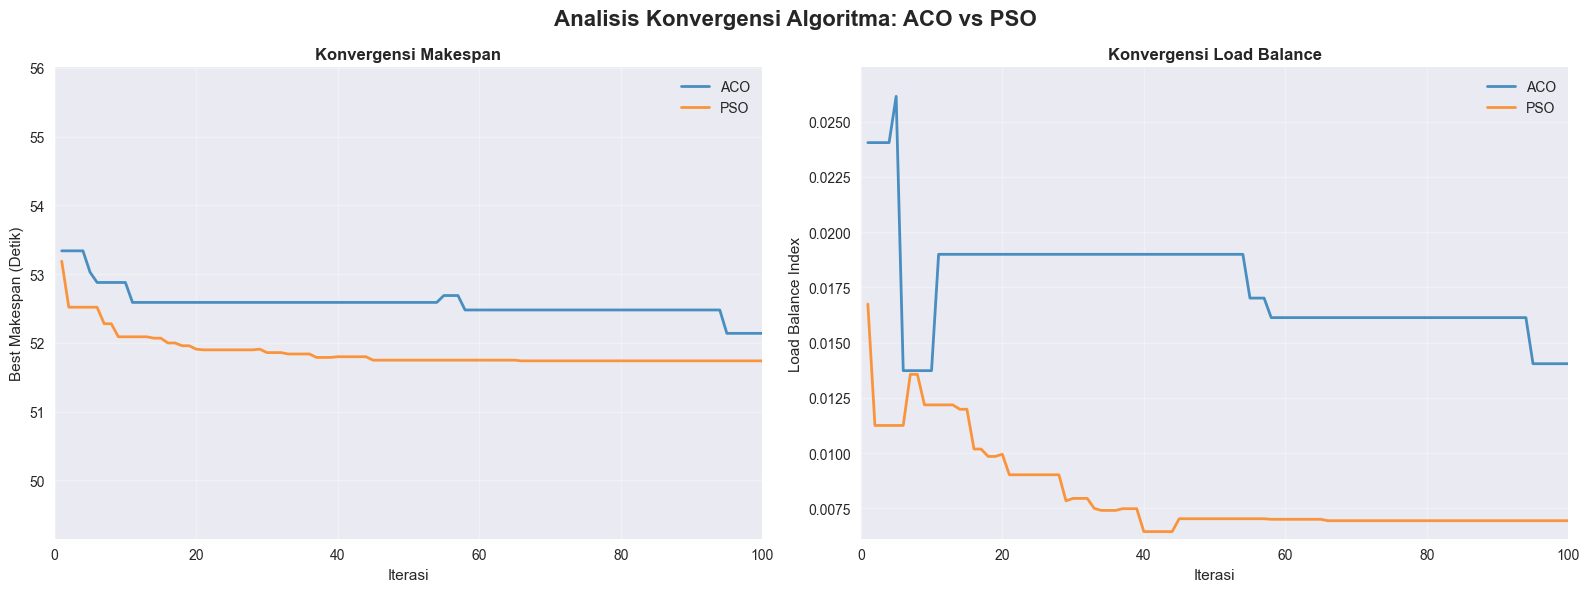


ANALISIS KONVERGENSI
ACO - Iterasi konvergensi: 100
      Makespan akhir: 52.14
      Load Balance akhir: 0.0140
PSO - Iterasi konvergensi: 100
      Makespan akhir: 51.74
      Load Balance akhir: 0.0069

Menampilkan Visualisasi 2: PERBANDINGAN METRIK


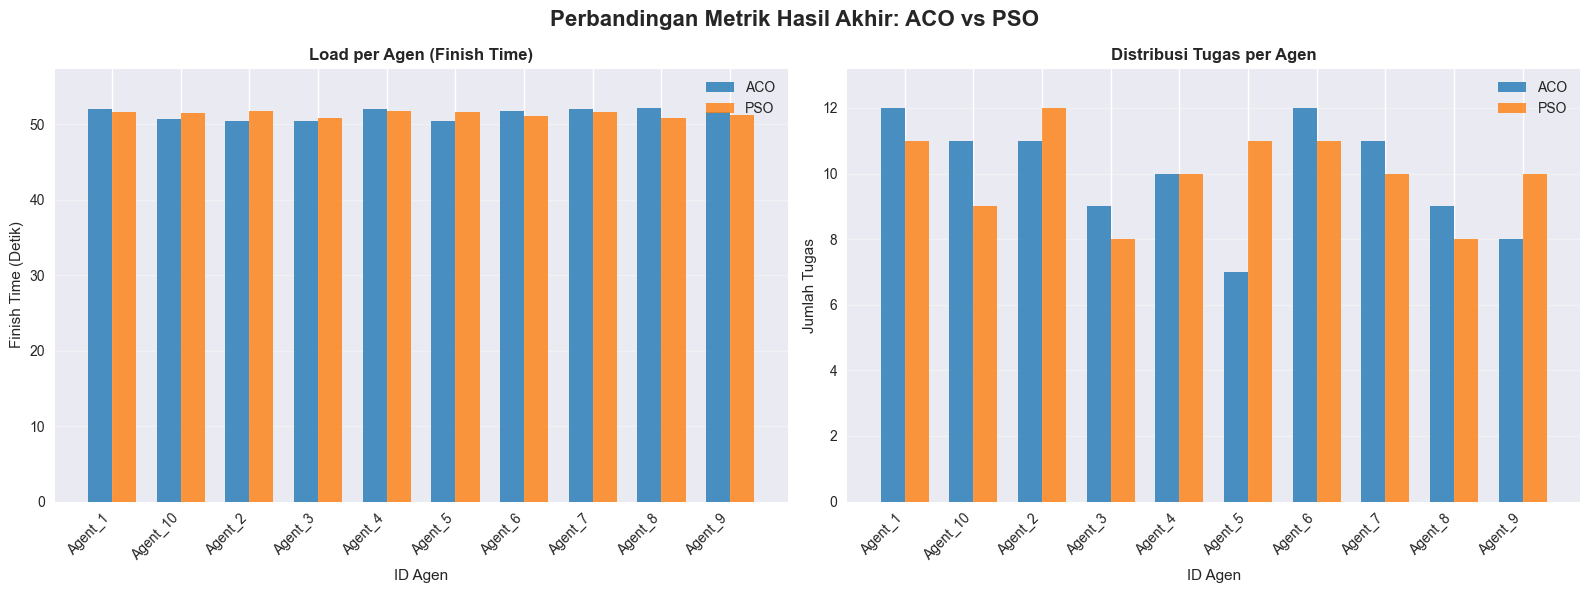


RINGKASAN VISUALISASI - PERILAKU ALGORITMA REALISTIS
Visualisasi berdasarkan hasil eksekusi algoritma yang sebenarnya
Pemenang: PSO
Data: 100 tugas, 10 agen
Dependencies: Ya

Analisis Performa:
   ACO - Makespan: 52.14, Load Balance: 0.0140
   PSO - Makespan: 51.74, Load Balance: 0.0069
   PSO lebih baik 0.8% dari ACO dalam makespan!


In [45]:
plt.rcParams['font.size'] = 10

# ========== KONSTANTA ==========
WARNA_ACO = '#1f77b4'
WARNA_PSO = '#ff7f0e'

# ========== EKSTRAKSI DATA ==========
def ekstrak_metrik(hasil):
    """Ekstrak semua metrik yang diperlukan dari hasil."""
    return {
        'riwayat_aco': hasil.get('aco', {}).get('result', {}).get('iteration_history', pd.DataFrame()),
        'riwayat_pso': hasil.get('pso', {}).get('result', {}).get('iteration_history', pd.DataFrame()),
        'makespan_aco': hasil['aco']['makespan'],
        'makespan_pso': hasil['pso']['makespan'],
        'lb_aco': hasil['aco']['load_balance'],
        'lb_pso': hasil['pso']['load_balance'],
        'waktu_agen_aco': hasil['aco'].get('agent_times', {}),
        'waktu_agen_pso': hasil['pso'].get('agent_times', {}),
        'jadwal_aco': hasil['aco'].get('schedule', pd.DataFrame()),
        'jadwal_pso': hasil['pso'].get('schedule', pd.DataFrame())
    }

def dapatkan_semua_agen(daftar_agen_aco, daftar_agen_pso):
    """Dapatkan list terurut dari semua ID agen yang unik."""
    return sorted(list(set(daftar_agen_aco + daftar_agen_pso)))

# ========== FUNGSI PLOTTING ==========
def plot_konvergensi(sumbu, riwayat_aco, riwayat_pso, metrik, judul, label_y, iterasi_maks):
    """Plot grafik konvergensi untuk makespan atau load balance."""
    if not riwayat_aco.empty:
        sumbu.plot(riwayat_aco['iteration'], riwayat_aco[metrik],
                color=WARNA_ACO, linewidth=2, label='ACO', alpha=0.8)
    if not riwayat_pso.empty:
        sumbu.plot(riwayat_pso['iteration'], riwayat_pso[metrik],
                color=WARNA_PSO, linewidth=2, label='PSO', alpha=0.8)

    sumbu.set_title(judul, fontweight='bold', fontsize=12)
    sumbu.set_xlabel('Iterasi')
    sumbu.set_ylabel(label_y)
    sumbu.legend()
    sumbu.grid(True, alpha=0.3)
    sumbu.set_xlim(0, iterasi_maks)

    # Auto-adjust y-axis
    semua_nilai = []
    if not riwayat_aco.empty:
        semua_nilai.extend(riwayat_aco[metrik].tolist())
    if not riwayat_pso.empty:
        semua_nilai.extend(riwayat_pso[metrik].tolist())

    if semua_nilai:
        y_min = min(semua_nilai) * 0.95 if min(semua_nilai) > 0 else 0
        y_max = max(semua_nilai) * 1.05 if max(semua_nilai) > 0 else 1
        sumbu.set_ylim(y_min, y_max)

def plot_perbandingan_agen(sumbu, id_agen_list, nilai_aco, nilai_pso, judul, label_y):
    """Plot perbandingan bar untuk agen."""
    if not id_agen_list:
        sumbu.set_title(judul, fontweight='bold', fontsize=12)
        sumbu.text(0.5, 0.5, "Data tidak tersedia", ha='center', va='center',
                transform=sumbu.transAxes)
        sumbu.set_xlabel("ID Agen")
        sumbu.set_ylabel(label_y)
        return

    x = np.arange(len(id_agen_list))
    lebar = 0.35

    sumbu.bar(x - lebar/2, nilai_aco, lebar, label='ACO', color=WARNA_ACO, alpha=0.8)
    sumbu.bar(x + lebar/2, nilai_pso, lebar, label='PSO', color=WARNA_PSO, alpha=0.8)

    sumbu.set_title(judul, fontweight='bold', fontsize=12)
    sumbu.set_xlabel('ID Agen')
    sumbu.set_ylabel(label_y)
    sumbu.set_xticks(x)

    # Rotasi label yang smart
    if len(id_agen_list) <= 20:
        sumbu.set_xticklabels(id_agen_list, rotation=45, ha='right')
    else:
        sumbu.set_xticklabels([f'{i+1}' for i in range(len(id_agen_list))])

    sumbu.legend()
    sumbu.grid(True, alpha=0.3, axis='y')

    # Auto-adjust y-axis
    if nilai_aco or nilai_pso:
        nilai_maks = max(max(nilai_aco, default=0), max(nilai_pso, default=0))
        sumbu.set_ylim(0, nilai_maks * 1.1)

def cetak_ringkasan(hasil):
    """Cetak ringkasan visualisasi."""
    print("\n" + "=" * 60)
    print("RINGKASAN VISUALISASI - PERILAKU ALGORITMA REALISTIS")
    print("=" * 60)

    info_dataset = hasil.get('dataset', {})
    hasil_aco = hasil.get('aco', {})
    hasil_pso = hasil.get('pso', {})

    print(f"Visualisasi berdasarkan hasil eksekusi algoritma yang sebenarnya")
    print(f"Pemenang: {hasil.get('winner', 'N/A')}")
    print(f"Data: {info_dataset.get('tasks', 0)} tugas, {info_dataset.get('agents', 0)} agen")
    print(f"Dependencies: {'Ya' if info_dataset.get('has_dependencies', False) else 'Tidak'}")

    # Analisis performa
    makespan_aco = hasil_aco.get('makespan', float('inf'))
    makespan_pso = hasil_pso.get('makespan', float('inf'))

    print(f"\nAnalisis Performa:")
    print(f"   ACO - Makespan: {makespan_aco:.2f}, Load Balance: {hasil_aco.get('load_balance', float('inf')):.4f}")
    print(f"   PSO - Makespan: {makespan_pso:.2f}, Load Balance: {hasil_pso.get('load_balance', float('inf')):.4f}")

    # Hitung peningkatan
    if makespan_aco != float('inf') and makespan_pso != float('inf'):
        if makespan_aco < makespan_pso:
            peningkatan = ((makespan_pso - makespan_aco) / makespan_pso) * 100
            print(f"   ACO lebih baik {peningkatan:.1f}% dari PSO dalam makespan!")
        elif makespan_pso < makespan_aco:
            peningkatan = ((makespan_aco - makespan_pso) / makespan_aco) * 100
            print(f"   PSO lebih baik {peningkatan:.1f}% dari ACO dalam makespan!")

# ========== VISUALISASI 1: KONVERGENSI ==========
def visualisasi_konvergensi(hasil):
    """Visualisasi grafik konvergensi algoritma."""
    if not hasil:
        print("Tidak ada hasil untuk divisualisasikan.")
        return

    # Ekstrak data
    data_metrik = ekstrak_metrik(hasil)
    iterasi_maks = max(config.aco_jumlah_iterasi, config.pso_jumlah_iterasi)

    # Buat figure untuk konvergensi
    gambar, sumbu_array = plt.subplots(1, 2, figsize=(16, 6))
    gambar.suptitle('Analisis Konvergensi Algoritma: ACO vs PSO',
                    fontsize=16, fontweight='bold')

    # 1. Konvergensi Makespan
    plot_konvergensi(sumbu_array[0], data_metrik['riwayat_aco'], data_metrik['riwayat_pso'],
                    'best_makespan', 'Konvergensi Makespan',
                    'Best Makespan (Detik)', iterasi_maks)

    # 2. Konvergensi Load Balance
    plot_konvergensi(sumbu_array[1], data_metrik['riwayat_aco'], data_metrik['riwayat_pso'],
                    'load_balance', 'Konvergensi Load Balance',
                    'Load Balance Index', iterasi_maks)

    plt.tight_layout()
    plt.show()

    # Ringkasan konvergensi
    print("\n" + "=" * 60)
    print("ANALISIS KONVERGENSI")
    print("=" * 60)

    if not data_metrik['riwayat_aco'].empty:
        print(f"ACO - Iterasi konvergensi: {len(data_metrik['riwayat_aco'])}")
        print(f"      Makespan akhir: {data_metrik['riwayat_aco']['best_makespan'].iloc[-1]:.2f}")
        print(f"      Load Balance akhir: {data_metrik['riwayat_aco']['load_balance'].iloc[-1]:.4f}")

    if not data_metrik['riwayat_pso'].empty:
        print(f"PSO - Iterasi konvergensi: {len(data_metrik['riwayat_pso'])}")
        print(f"      Makespan akhir: {data_metrik['riwayat_pso']['best_makespan'].iloc[-1]:.2f}")
        print(f"      Load Balance akhir: {data_metrik['riwayat_pso']['load_balance'].iloc[-1]:.4f}")

# ========== VISUALISASI 2: PERBANDINGAN ==========
def visualisasi_perbandingan_metrik(hasil):
    """Visualisasi perbandingan metrik hasil akhir."""
    if not hasil:
        print("Tidak ada hasil untuk divisualisasikan.")
        return

    # Ekstrak data
    data_metrik = ekstrak_metrik(hasil)

    # Buat figure untuk perbandingan
    gambar, sumbu_array = plt.subplots(1, 2, figsize=(16, 6))
    gambar.suptitle('Perbandingan Metrik Hasil Akhir: ACO vs PSO',
                    fontsize=16, fontweight='bold')

    # 1. Load Agen (Finish Times)
    semua_agen = dapatkan_semua_agen(list(data_metrik['waktu_agen_aco'].keys()),
                                     list(data_metrik['waktu_agen_pso'].keys()))

    # Jika tidak ada data dari waktu_agen, coba dari jadwal
    if not semua_agen and not data_metrik['jadwal_aco'].empty and not data_metrik['jadwal_pso'].empty:
        semua_agen = dapatkan_semua_agen(
            data_metrik['jadwal_aco']['agent_id'].unique().tolist(),
            data_metrik['jadwal_pso']['agent_id'].unique().tolist()
        )

    waktu_selesai_aco = [data_metrik['waktu_agen_aco'].get(a, 0) for a in semua_agen]
    waktu_selesai_pso = [data_metrik['waktu_agen_pso'].get(a, 0) for a in semua_agen]

    plot_perbandingan_agen(sumbu_array[0], semua_agen, waktu_selesai_aco, waktu_selesai_pso,
                         'Load per Agen (Finish Time)',
                         'Finish Time (Detik)')

    # 2. Distribusi Task
    if not data_metrik['jadwal_aco'].empty and not data_metrik['jadwal_pso'].empty:
        tugas_aco = data_metrik['jadwal_aco']['agent_id'].value_counts().reindex(semua_agen, fill_value=0).tolist()
        tugas_pso = data_metrik['jadwal_pso']['agent_id'].value_counts().reindex(semua_agen, fill_value=0).tolist()

        plot_perbandingan_agen(sumbu_array[1], semua_agen, tugas_aco, tugas_pso,
                             'Distribusi Tugas per Agen',
                             'Jumlah Tugas')
    else:
        plot_perbandingan_agen(sumbu_array[1], [], [], [],
                             'Distribusi Tugas per Agen',
                             'Jumlah Tugas')

    plt.tight_layout()
    plt.show()

    # Cetak ringkasan lengkap
    cetak_ringkasan(hasil)

# ========== EKSEKUSI ==========
if 'hasil_perbandingan' in locals() and hasil_perbandingan is not None:
    print("Menampilkan Visualisasi 1: KONVERGENSI")
    visualisasi_konvergensi(hasil_perbandingan)

    print("\n" + "="*60)
    print("Menampilkan Visualisasi 2: PERBANDINGAN METRIK")
    print("="*60)
    visualisasi_perbandingan_metrik(hasil_perbandingan)
else:
    print("Tidak ada hasil untuk divisualisasikan.")
    print("Silakan jalankan perbandingan terlebih dahulu (cell sebelumnya).")

## Daftar Agen dan Tugas

In [46]:
print("Daftar Agen:")
if 'agen' in locals() and agen:
    if isinstance(agen, list):
        display(pd.DataFrame(agen))
    else:
        display(agen)
else:
    print("Variabel 'agen' tidak ditemukan atau kosong.")

print("\nDaftar Tugas:")
if 'tugas' in locals() and tugas:
    if isinstance(tugas, list):
        display(pd.DataFrame(tugas))
    else:
         display(tugas)
else:
    print("Variabel 'tugas' tidak ditemukan atau kosong.")

Daftar Agen:


,id,type,capacity,efficiency
0,Agent_1,High_Performance,1.5,1.2
1,Agent_2,Medium_Performance,1.4,1.1
2,Agent_3,Standard,1.3,1.0
3,Agent_4,Basic,1.2,0.9
4,Agent_5,High_Performance,1.1,0.8
5,Agent_6,Medium_Performance,1.0,0.7
6,Agent_7,Standard,0.9,1.2
7,Agent_8,Basic,0.8,1.1
8,Agent_9,High_Performance,0.7,1.0
9,Agent_10,Medium_Performance,1.5,0.9



Daftar Tugas:


,id,duration,cpu_usage,ram_usage,priority,cost,dependencies,complexity
0,1,1.27,37,2612,2,1.27,[],0.198060
1,2,3.71,86,11761,3,3.71,[],0.488805
2,3,8.53,44,4610,2,8.53,[],0.243050
3,4,7.31,82,12604,3,7.31,[3],0.473020
4,5,1.76,59,15945,1,1.76,[],0.374725
...,...,...,...,...,...,...,...,...
95,96,2.37,31,9602,2,2.37,[35],0.203010
96,97,2.83,51,9131,2,2.83,[],0.300655
97,98,4.45,45,12057,2,4.45,[],0.285285
98,99,3.31,51,12385,1,3.31,[56],0.316925


## Full Schedule DataFrame

In [47]:
print("Menampilkan DataFrame Jadwal Lengkap:")
print("=" * 30)

if 'hasil_perbandingan' in locals() and hasil_perbandingan is not None:
    df_jadwal_aco = hasil_perbandingan.get('aco', {}).get('schedule', pd.DataFrame())
    df_jadwal_pso = hasil_perbandingan.get('pso', {}).get('schedule', pd.DataFrame())
    label_sumber = "dari hasil standar"
elif 'hasil_enhanced' in locals() and hasil_enhanced is not None:
    df_jadwal_aco = hasil_enhanced.get('aco_result', {}).get('schedule', pd.DataFrame())
    df_jadwal_pso = hasil_enhanced.get('pso_result', {}).get('schedule', pd.DataFrame())
    label_sumber = "dari hasil enhanced"
else:
    df_jadwal_aco = pd.DataFrame()
    df_jadwal_pso = pd.DataFrame()
    label_sumber = "Tidak ada hasil ditemukan"


if not df_jadwal_aco.empty:
    print(f"\n--- DataFrame Jadwal untuk ACO ({label_sumber}) ---")
    display(df_jadwal_aco)
else:
    print(f"\n--- DataFrame Jadwal ACO kosong atau tidak ditemukan ({label_sumber}) ---")

if not df_jadwal_pso.empty:
    print(f"\n--- DataFrame Jadwal untuk PSO ({label_sumber}) ---")
    display(df_jadwal_pso)
else:
    print(f"\n--- DataFrame Jadwal PSO kosong atau tidak ditemukan ({label_sumber}) ---")


print("\n" + "=" * 30)

Menampilkan DataFrame Jadwal Lengkap:

--- DataFrame Jadwal untuk ACO (dari hasil standar) ---


,task_id,agent_id,start_time,finish_time
0,97,Agent_1,0.00,2.83
1,71,Agent_2,0.00,4.73
2,96,Agent_3,0.00,2.37
3,55,Agent_4,0.00,3.24
4,85,Agent_5,0.00,9.93
...,...,...,...,...
95,10,Agent_8,47.36,52.14
96,36,Agent_9,48.06,51.64
97,34,Agent_2,48.49,50.41
98,75,Agent_1,48.60,52.06



--- DataFrame Jadwal untuk PSO (dari hasil standar) ---


,task_id,agent_id,start_time,finish_time
0,27,Agent_1,0.00,5.95
1,69,Agent_2,0.00,8.96
2,64,Agent_3,0.00,3.08
3,89,Agent_4,0.00,9.96
4,90,Agent_5,0.00,7.84
...,...,...,...,...
95,9,Agent_6,47.39,50.01
96,37,Agent_5,48.16,51.65
97,99,Agent_7,48.28,51.59
98,97,Agent_4,48.91,51.74


## Gantt Chart Visualization

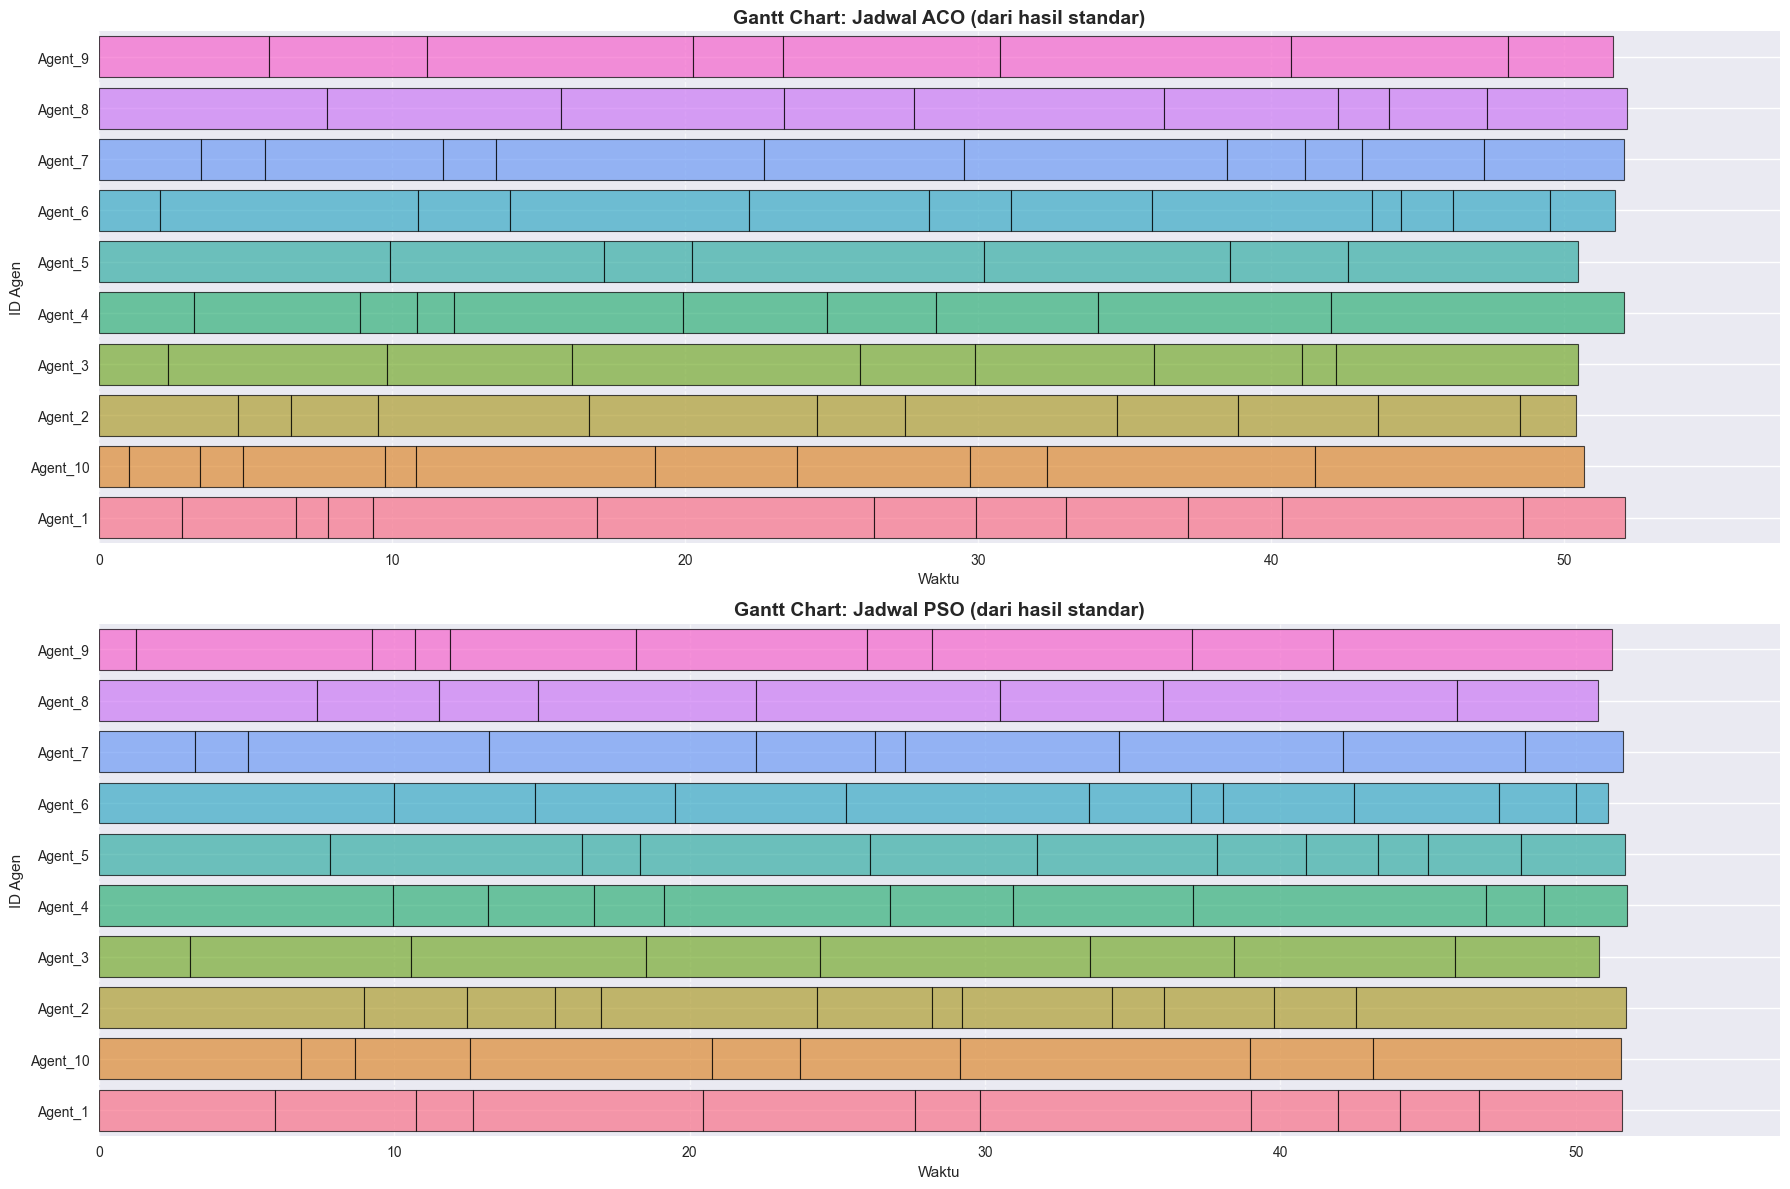

In [48]:
# ========== VISUALISASI GANTT CHART ==========

def buat_gantt_chart(df_jadwal, judul, sumbu):
    """Render Gantt chart untuk schedule DataFrame pada Axes yang diberikan."""
    if df_jadwal is None or df_jadwal.empty:
        sumbu.set_title(f"Gantt Chart: {judul} (Tidak Ada Data)")
        sumbu.text(0.5, 0.5, "DataFrame jadwal kosong.",
                ha='center', va='center', transform=sumbu.transAxes)
        sumbu.set_xlabel("Waktu")
        sumbu.set_ylabel("ID Agen")
        return

    df_jadwal = df_jadwal.sort_values(['agent_id', 'start_time'])
    daftar_agen = df_jadwal['agent_id'].dropna().unique().tolist()
    peta_indeks = {agen: i for i, agen in enumerate(daftar_agen)}
    warna = sns.color_palette("husl", len(daftar_agen))

    for _, baris in df_jadwal.iterrows():
        posisi_y = peta_indeks[baris['agent_id']]
        waktu_mulai = float(baris['start_time'])
        waktu_selesai = float(baris['finish_time'])
        durasi = max(waktu_selesai - waktu_mulai, 0)
        sumbu.add_patch(patches.Rectangle(
            (waktu_mulai, posisi_y - 0.4), durasi, 0.8,
            facecolor=warna[posisi_y % len(warna)],
            edgecolor='black', linewidth=0.8, alpha=0.7
        ))

    sumbu.set_yticks(list(peta_indeks.values()))
    sumbu.set_yticklabels(list(peta_indeks.keys()))
    sumbu.set_ylim(-0.5, len(daftar_agen) - 0.5)

    waktu_maks = float(df_jadwal['finish_time'].max())
    sumbu.set_xlim(0, waktu_maks * 1.1 if waktu_maks > 0 else 1)

    sumbu.set_title(f'Gantt Chart: {judul}', fontweight='bold', fontsize=14)
    sumbu.set_xlabel('Waktu')
    sumbu.set_ylabel('ID Agen')
    sumbu.grid(True, axis='x', linestyle='--', alpha=0.6)


def dapatkan_jadwal_dari_konteks():
    """Ambil ACO/PSO schedule dari variabel konteks (hasil_perbandingan/hasil_enhanced)."""
    if 'hasil_perbandingan' in globals() and hasil_perbandingan is not None:
        return (
            hasil_perbandingan.get('aco', {}).get('schedule', pd.DataFrame()),
            hasil_perbandingan.get('pso', {}).get('schedule', pd.DataFrame()),
            "dari hasil standar"
        )
    if 'hasil_enhanced' in globals() and hasil_enhanced is not None:
        return (
            hasil_enhanced.get('aco_result', {}).get('schedule', pd.DataFrame()),
            hasil_enhanced.get('pso_result', {}).get('schedule', pd.DataFrame()),
            "dari hasil enhanced"
        )
    return pd.DataFrame(), pd.DataFrame(), "Tidak ada hasil ditemukan"


def plot_gantt_dari_konteks():
    """Plot Gantt chart ACO/PSO berdasarkan konteks global hasil_perbandingan/hasil_enhanced."""
    df_aco, df_pso, label = dapatkan_jadwal_dari_konteks()

    if df_aco.empty and df_pso.empty:
        print("Hasil perbandingan tidak ditemukan. Tidak dapat menghasilkan Gantt chart.")
        return

    jumlah_plot = int(not df_aco.empty) + int(not df_pso.empty)
    gambar, sumbu_array = plt.subplots(jumlah_plot, 1, figsize=(18, 6 * jumlah_plot))
    sumbu_array = [sumbu_array] if jumlah_plot == 1 else sumbu_array.flatten()

    indeks = 0
    if not df_aco.empty:
        buat_gantt_chart(df_aco, f'Jadwal ACO ({label})', sumbu_array[indeks])
        indeks += 1
    if not df_pso.empty:
        buat_gantt_chart(df_pso, f'Jadwal PSO ({label})', sumbu_array[indeks])

    plt.tight_layout()
    plt.show()


# Eksekusi langsung (opsional):
if 'hasil_perbandingan' in globals() or 'hasil_enhanced' in globals():
    plot_gantt_dari_konteks()
else:
    print("Tidak ada hasil ditemukan. Silakan jalankan perbandingan terlebih dahulu.")

## Agent Workload Heatmap (Finish Time)

Visualisasi beban kerja agen (berdasarkan waktu selesai) menggunakan heatmap.


Menghasilkan Heatmap Beban Kerja Agen...


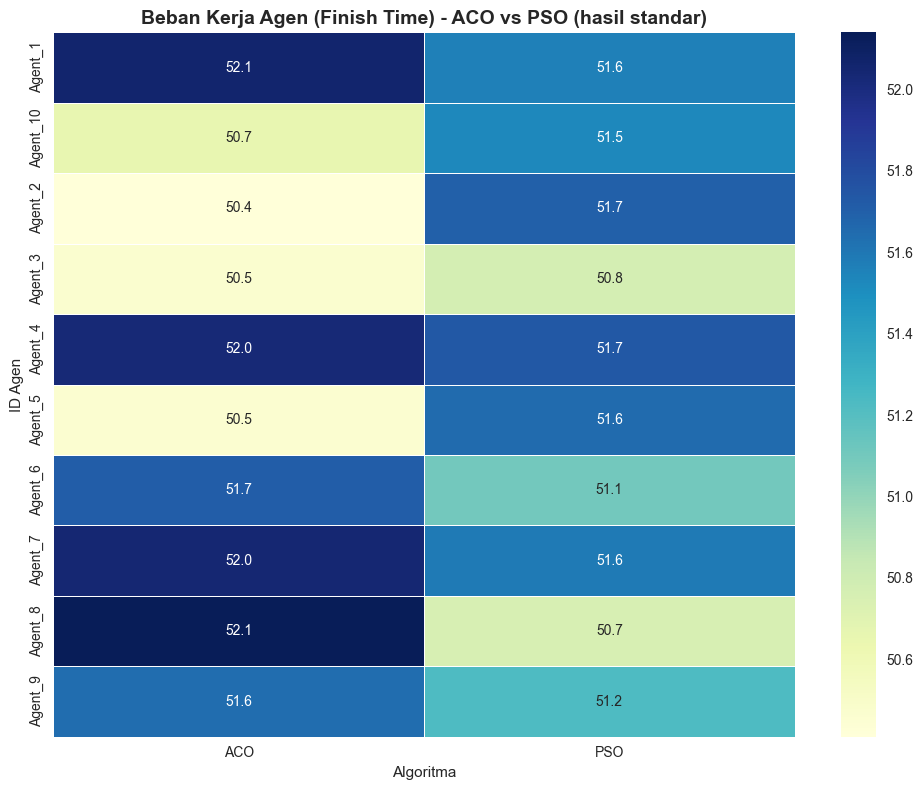


💡 Warna lebih gelap = beban kerja lebih berat


In [49]:
# ========== VISUALISASI HEATMAP FINISH TIME ==========

def plot_heatmap_beban_kerja():
    """Generate heatmap beban kerja agen membandingkan ACO dan PSO."""
    print("\n" + "=" * 50)
    print("Menghasilkan Heatmap Beban Kerja Agen...")
    print("=" * 50)

    # Dapatkan data dari hasil
    waktu_aco, waktu_pso = {}, {}
    sumber = "tidak ada hasil"

    if 'hasil_perbandingan' in globals() and hasil_perbandingan:
        waktu_aco = hasil_perbandingan.get('aco', {}).get('agent_times', {})
        waktu_pso = hasil_perbandingan.get('pso', {}).get('agent_times', {})
        sumber = "hasil standar"
    elif 'hasil_enhanced' in globals() and hasil_enhanced:
        waktu_aco = hasil_enhanced.get('aco_result', {}).get('agent_finish_times', {})
        waktu_pso = hasil_enhanced.get('pso_result', {}).get('agent_finish_times', {})
        sumber = "hasil enhanced"

    # Validasi
    if not waktu_aco and not waktu_pso:
        print("Tidak ada waktu selesai agen ditemukan. Silakan jalankan perbandingan terlebih dahulu.")
        return

    # Buat dataframe
    daftar_data = [{'Agent_ID': id_agen, 'Algorithm': algoritma, 'Finish_Time': waktu_selesai}
            for algoritma, waktu_dict in [('ACO', waktu_aco), ('PSO', waktu_pso)]
            for id_agen, waktu_selesai in waktu_dict.items()]

    if not daftar_data:
        print("Tidak ada data valid tersedia.")
        return

    # Buat pivot dan plot
    df = pd.DataFrame(daftar_data)
    semua_agen = sorted(set(waktu_aco.keys()) | set(waktu_pso.keys()))
    data_heatmap = df.pivot_table(index='Agent_ID', columns='Algorithm',
                             values='Finish_Time').reindex(semua_agen)

    plt.figure(figsize=(10, 8))
    sns.heatmap(data_heatmap, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.5)
    plt.title(f'Beban Kerja Agen (Finish Time) - ACO vs PSO ({sumber})',
              fontsize=14, fontweight='bold')
    plt.xlabel('Algoritma')
    plt.ylabel('ID Agen')
    plt.tight_layout()
    plt.show()

    print("\n💡 Warna lebih gelap = beban kerja lebih berat")
    print("=" * 50)

# Eksekusi
plot_heatmap_beban_kerja()

## Agent Workload Heatmap (Beban Kerja)

Visualisasi beban kerja agen (berdasarkan pembagian beban kerja) menggunakan heatmap.


Menghasilkan Heatmap Beban Kerja Agen (Jumlah Tugas)...


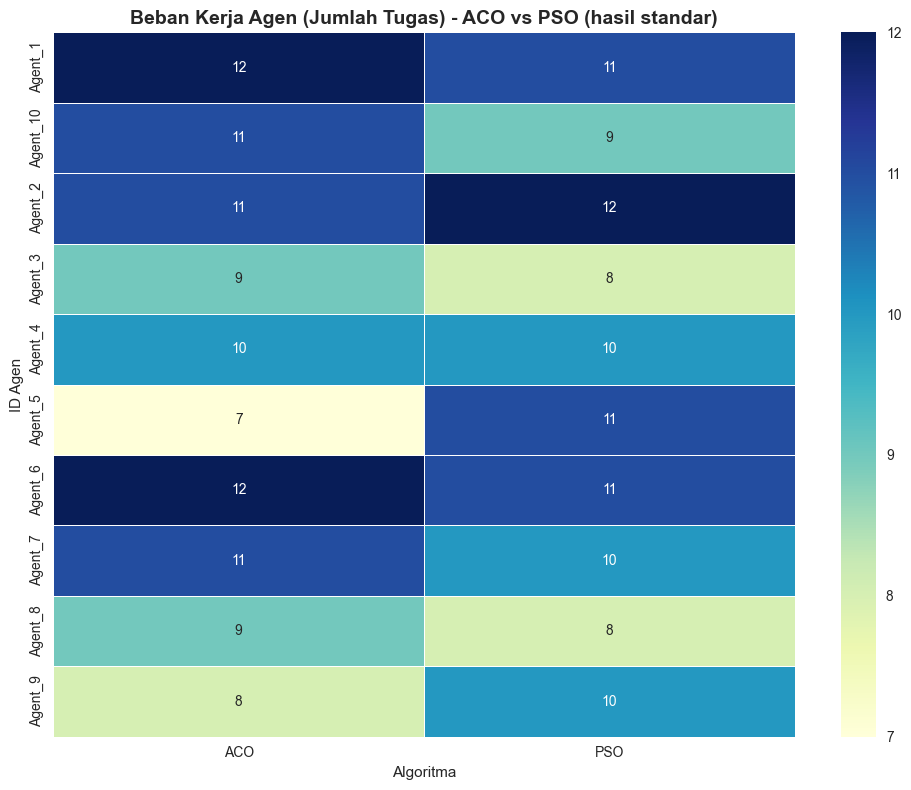


💡 Warna lebih gelap = lebih banyak tugas yang ditugaskan


In [50]:
# ========== VISUALISASI HEATMAP BEBAN TUGAS ==========

def plot_heatmap_beban_tugas():
    """Generate heatmap beban tugas agen membandingkan ACO dan PSO."""
    print("\n" + "=" * 50)
    print("Menghasilkan Heatmap Beban Kerja Agen (Jumlah Tugas)...")
    print("=" * 50)

    # Dapatkan jadwal dari hasil
    df_aco, df_pso, sumber = pd.DataFrame(), pd.DataFrame(), "tidak ada hasil"

    if 'hasil_perbandingan' in globals() and hasil_perbandingan:
        df_aco = hasil_perbandingan.get('aco', {}).get('schedule', pd.DataFrame())
        df_pso = hasil_perbandingan.get('pso', {}).get('schedule', pd.DataFrame())
        sumber = "hasil standar"
    elif 'hasil_enhanced' in globals() and hasil_enhanced:
        df_aco = hasil_enhanced.get('aco_result', {}).get('schedule', pd.DataFrame())
        df_pso = hasil_enhanced.get('pso_result', {}).get('schedule', pd.DataFrame())
        sumber = "hasil enhanced"

    # Validasi
    if df_aco.empty and df_pso.empty:
        print("Tidak ada data jadwal ditemukan. Silakan jalankan perbandingan terlebih dahulu.")
        print("=" * 50)
        return

    # Hitung jumlah tugas
    jumlah_aco = df_aco['agent_id'].value_counts().reset_index()
    jumlah_aco.columns = ['Agent_ID', 'Task_Count']
    jumlah_aco['Algorithm'] = 'ACO'

    jumlah_pso = df_pso['agent_id'].value_counts().reset_index()
    jumlah_pso.columns = ['Agent_ID', 'Task_Count']
    jumlah_pso['Algorithm'] = 'PSO'

    # Buat pivot table
    df_gabungan = pd.concat([jumlah_aco, jumlah_pso])
    if df_gabungan.empty:
        print("Tidak ada data jumlah tugas valid tersedia.")
        return

    data_heatmap = df_gabungan.pivot_table(index='Agent_ID', columns='Algorithm',
                             values='Task_Count').reindex(sorted(df_gabungan['Agent_ID'].unique()))

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(data_heatmap, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5)
    plt.title(f'Beban Kerja Agen (Jumlah Tugas) - ACO vs PSO ({sumber})',
              fontsize=14, fontweight='bold')
    plt.xlabel('Algoritma')
    plt.ylabel('ID Agen')
    plt.tight_layout()
    plt.show()

    print("\n💡 Warna lebih gelap = lebih banyak tugas yang ditugaskan")
    print("=" * 50)

# Eksekusi
plot_heatmap_beban_tugas()

## Multi-Run Comparison

Untuk mendapatkan hasil yang lebih valid, disini akan menjalankan kedua algoritma (ACO dan PSO) beberapa kali dan menganalisis hasil rata-rata serta variabilitasnya.

In [51]:
# from IPython.display import display

# def jalankan_perbandingan_multi(jumlah_run, seed_dasar=42):
#     """Jalankan beberapa perbandingan dengan statistik komprehensif."""
#     print(f"\n{'='*60}\nMemulai Perbandingan Multi-Run ({jumlah_run} run)\n{'='*60}")

#     # Jalankan perbandingan
#     daftar_hasil = []
#     for i in range(1, jumlah_run + 1):
#         seed = seed_dasar + i
#         np.random.seed(seed); random.seed(seed)
#         print(f"\n--- Run {i}/{jumlah_run} (seed: {seed}) ---")

#         # Inisialisasi & jalankan
#         penjadwal_aco = buat_scheduler_aco(tugas, agen, config, seed, tampilkan_detail=False)
#         penjadwal_pso = buat_scheduler_pso(tugas, agen, config, seed, tampilkan_detail=False)

#         t0 = time.time(); hasil_aco = penjadwal_aco.optimize(show_progress=False); waktu_aco = time.time() - t0
#         t0 = time.time(); hasil_pso = penjadwal_pso.optimize(show_progress=False); waktu_pso = time.time() - t0

#         daftar_hasil.append({
#             'run': i,
#             'aco_makespan': hasil_aco.get('makespan', float('inf')),
#             'aco_load_balance': hasil_aco.get('load_balance_index', float('inf')),
#             'aco_time': waktu_aco,
#             'pso_makespan': hasil_pso.get('makespan', float('inf')),
#             'pso_load_balance': hasil_pso.get('load_balance_index', float('inf')),
#             'pso_time': waktu_pso,
#             'aco_schedule': hasil_aco.get('schedule'),
#             'pso_schedule': hasil_pso.get('schedule'),
#             'aco_agent_times': hasil_aco.get('agent_finish_times'),
#             'pso_agent_times': hasil_pso.get('agent_finish_times'),
#         })
#         print(f"   ✓ ACO: {daftar_hasil[-1]['aco_makespan']:.2f} | PSO: {daftar_hasil[-1]['pso_makespan']:.2f}")

#     # Buat DataFrame
#     df_hasil = pd.DataFrame(daftar_hasil)
#     metrik_list = ['aco_makespan', 'aco_load_balance', 'aco_time',
#                    'pso_makespan', 'pso_load_balance', 'pso_time']

#     # Tabel ringkasan
#     ringkasan = pd.DataFrame({
#         'Mean': df_hasil[metrik_list].mean(),
#         'Std': df_hasil[metrik_list].std(),
#         'Min': df_hasil[metrik_list].min(),
#         'Max': df_hasil[metrik_list].max(),
#         'Median': df_hasil[metrik_list].median()
#     })
#     ringkasan.index = ringkasan.index.str.replace('_', ' ').str.title()

#     # Cetak hasil
#     print(f"\n{'='*60}\nRINGKASAN MULTI-RUN\n{'='*60}")
#     print("\nRingkasan Statistik:")
#     display(ringkasan.round(4))

#     # Pemenang
#     rata_rata = df_hasil[metrik_list].mean()
#     makespan_aco, makespan_pso = rata_rata['aco_makespan'], rata_rata['pso_makespan']

#     print(f"\n{'='*60}\nANALISIS PEMENANG\n{'='*60}")
#     if makespan_aco < makespan_pso:
#         peningkatan = ((makespan_pso - makespan_aco) / makespan_pso * 100)
#         print(f"ACO menang! ({makespan_aco:.2f} vs {makespan_pso:.2f}) | Peningkatan: {peningkatan:.2f}%")
#     elif makespan_pso < makespan_aco:
#         peningkatan = ((makespan_aco - makespan_pso) / makespan_aco * 100)
#         print(f"PSO menang! ({makespan_pso:.2f} vs {makespan_aco:.2f}) | Peningkatan: {peningkatan:.2f}%")
#     else:
#         print(f"Seri! ({makespan_aco:.2f})")

#     print(f"\nLoad Balance: ACO {rata_rata['aco_load_balance']:.4f} | PSO {rata_rata['pso_load_balance']:.4f}")
#     print(f"Waktu Eksekusi: ACO {rata_rata['aco_time']:.3f}s | PSO {rata_rata['pso_time']:.3f}s")

#     # Hasil detail
#     print(f"\n{'='*60}\nHASIL DETAIL\n{'='*60}")
#     display(df_hasil[['run'] + metrik_list].round(4))

#     print("\nPerbandingan Multi-Run Selesai!")

#     global df_hasil_multi_run
#     df_hasil_multi_run = df_hasil
#     return df_hasil

# # Eksekusi
# df_hasil_multi_run = jalankan_perbandingan_multi(jumlah_run=10)